In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_d_epoch(epoch, generator, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update True/Fake D network
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())

        tf_dis = 0
        for _y_cls, _y_pr_cls in \
            zip(y_cls, y_pr_cls):
            B, C = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                            tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (2) Update Edge D network
        ###########################        
        edge_d_optim.zero_grad()        
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in \
            zip(edge_y_cls, edge_pr_cls):
            B, C = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)

        edge_dis_l += edge_dis.item()


    return  edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
def train_g_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, edge_discriminator, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    mae_l = 0
    tf_gen_l = 0
    edge_gen_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()

        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        
        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  mae_l/(index+1), air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1)

In [20]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C = _y_cls.size()
            total = B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            total = B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]

 
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  

        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C = _edge_y_cls.size()
            total = B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            total = B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        

        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [21]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [22]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [23]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [24]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [25]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [26]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [27]:
train_case_path = 'raw/train/*_*'
train_id_case_path = "raw/train_id/*_*"
test_case_path = 'raw/test/*_*'

In [28]:
trainset = Dataset(train_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=True, position="pelvic")
trainset_id = Dataset(train_id_case_path, 
                      intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=True, position="pelvic")
trainset = ConcatDataset([trainset, trainset_id])

testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation(), 
                 identity=False, electron=False, position="pelvic")

In [29]:
len(trainset), len(testset)

(1344, 191)

In [30]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f446afe8280>,)

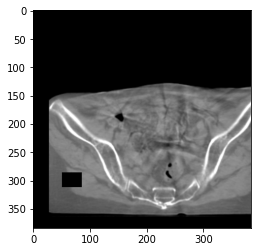

In [31]:
plt.imshow(x.squeeze(), 'gray'),

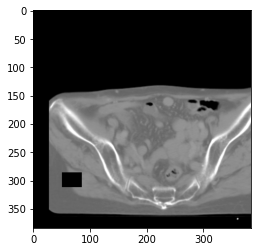

In [32]:
plt.imshow(y.squeeze(), 'gray')

In [33]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [34]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [35]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [36]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [37]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [39]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [40]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=15, T_mult=5)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=15, T_mult=5)

In [41]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [42]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_d_epoch(epoch, model,                                                                                              
                                                                                                                       tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                                                        edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                                                        trainloader, device)
        loss_mae, loss_air, loss_bone, loss_edge_gen, loss_tf_gen = train_g_epoch(epoch, model, gen_optimizer, 
                                                                                                                                             tf_discriminator, edge_discriminator,
                                                                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [01:41,  3.30it/s]
336it [03:50,  1.46it/s]
336it [01:28,  3.79it/s]
48it [00:13,  3.64it/s]
336it [01:54,  2.93it/s]
336it [03:58,  1.41it/s]
336it [01:19,  4.22it/s]
48it [00:11,  4.05it/s]
336it [01:40,  3.34it/s]
336it [03:45,  1.49it/s]
336it [01:11,  4.69it/s]
48it [00:11,  4.05it/s]
336it [01:55,  2.90it/s]
336it [03:55,  1.43it/s]
336it [01:23,  4.02it/s]
48it [00:10,  4.72it/s]
336it [01:47,  3.14it/s]
336it [03:24,  1.64it/s]
336it [01:20,  4.17it/s]
48it [00:10,  4.58it/s]
336it [01:48,  3.11it/s]
336it [03:23,  1.65it/s]
336it [01:02,  5.36it/s]
48it [00:08,  5.54it/s]
336it [01:26,  3.89it/s]
336it [03:14,  1.73it/s]
336it [01:02,  5.41it/s]
48it [00:08,  5.50it/s]
336it [01:26,  3.91it/s]
336it [02:58,  1.88it/s]
336it [01:01,  5.44it/s]
48it [00:08,  5.55it/s]
336it [01:26,  3.91it/s]
336it [03:15,  1.72it/s]
336it [01:01,  5.44it/s]
48it [00:10,  4.77it/s]
336it [01:43,  3.25it/s]
336it [03:29,  1.60it/s]
336it [01:11,  4.69it/s]
48it [00:11,  4.20it/s]
336it [01:

In [43]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [44]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [45]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8866362571716309
psnr score = 25.739273071289062
snr score = 15.802212715148926
mae error = 0.01681588776409626
air dice score = 0.9971944676871612
bone dice score = 0.9269037082263558
contour dice score = 0.5346062183380127


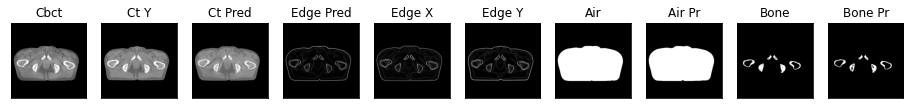

1it [00:00,  2.08it/s]

ssim score = 0.8849118947982788
psnr score = 25.576608657836914
snr score = 15.68708324432373
mae error = 0.017264312133193016
air dice score = 0.9970881618037686
bone dice score = 0.9228650137752852
contour dice score = 0.5122681260108948


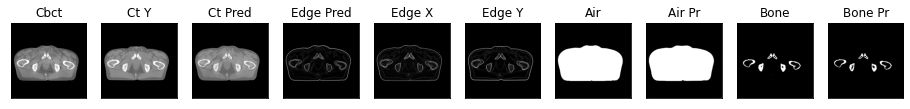

2it [00:00,  2.23it/s]

ssim score = 0.8803003430366516
psnr score = 25.292444229125977
snr score = 15.565814971923828
mae error = 0.018368003889918327
air dice score = 0.9966345869988815
bone dice score = 0.9023849863169244
contour dice score = 0.5251196026802063


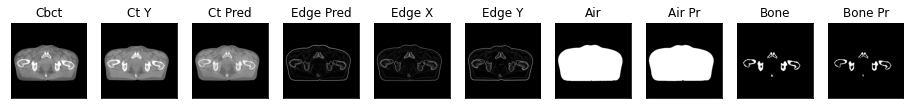

3it [00:01,  2.00it/s]

ssim score = 0.875829815864563
psnr score = 25.09552001953125
snr score = 15.45814323425293
mae error = 0.01972668431699276
air dice score = 0.9972679481995115
bone dice score = 0.8690504952902989
contour dice score = 0.6114113926887512


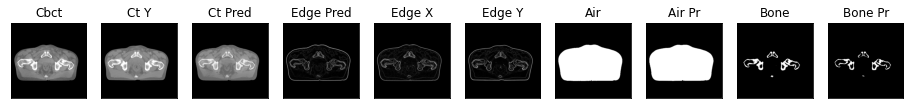

4it [00:01,  2.17it/s]

ssim score = 0.8733844757080078
psnr score = 25.1088924407959
snr score = 15.51181697845459
mae error = 0.02015828527510166
air dice score = 0.9977441377263305
bone dice score = 0.831407739766333
contour dice score = 0.625


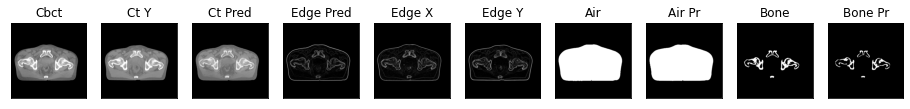

5it [00:02,  2.31it/s]

ssim score = 0.8689302206039429
psnr score = 24.816015243530273
snr score = 15.355473518371582
mae error = 0.021571042016148567
air dice score = 0.9979246313489917
bone dice score = 0.7922154511520324
contour dice score = 0.7080820202827454


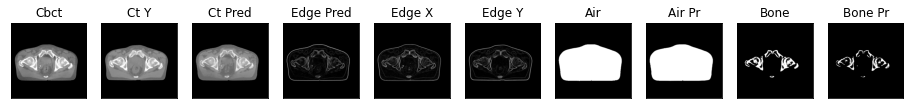

6it [00:02,  2.42it/s]

ssim score = 0.8683587312698364
psnr score = 24.737890243530273
snr score = 15.253291130065918
mae error = 0.02166523039340973
air dice score = 0.9977515064906535
bone dice score = 0.7886870979967018
contour dice score = 0.6892381906509399


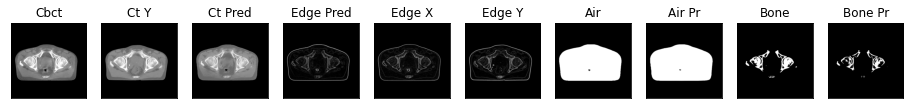

7it [00:02,  2.49it/s]

ssim score = 0.8696985244750977
psnr score = 25.26126480102539
snr score = 15.591130256652832
mae error = 0.020179104059934616
air dice score = 0.997548132963546
bone dice score = 0.8367367468077986
contour dice score = 0.6221952438354492


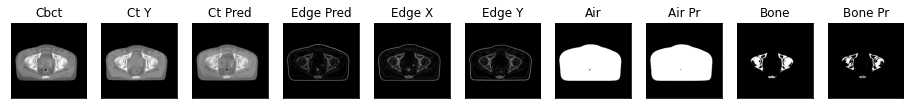

8it [00:03,  2.54it/s]

ssim score = 0.8702690005302429
psnr score = 25.64305877685547
snr score = 15.878366470336914
mae error = 0.01932286098599434
air dice score = 0.9975341081354244
bone dice score = 0.880338266386043
contour dice score = 0.6029232740402222


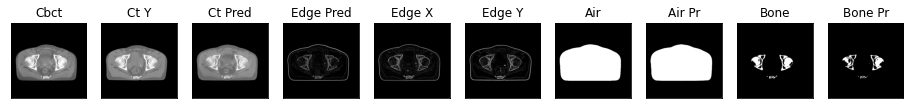

9it [00:03,  2.57it/s]

ssim score = 0.875621497631073
psnr score = 25.69464683532715
snr score = 15.914674758911133
mae error = 0.01902604103088379
air dice score = 0.9976798143851532
bone dice score = 0.8845814977986278
contour dice score = 0.5503355860710144


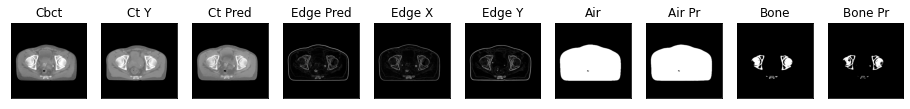

10it [00:04,  2.61it/s]

ssim score = 0.8807148337364197
psnr score = 25.999916076660156
snr score = 16.25221061706543
mae error = 0.018402405083179474
air dice score = 0.997543902738551
bone dice score = 0.9111237877933699
contour dice score = 0.5220049023628235


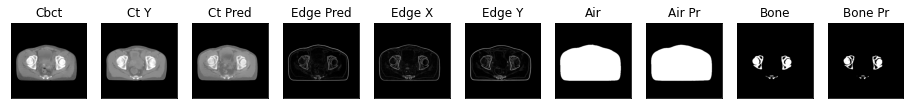

11it [00:04,  2.64it/s]

ssim score = 0.879732608795166
psnr score = 25.105857849121094
snr score = 15.381864547729492
mae error = 0.019708560779690742
air dice score = 0.9971136836224852
bone dice score = 0.8913726859949775
contour dice score = 0.5299877524375916


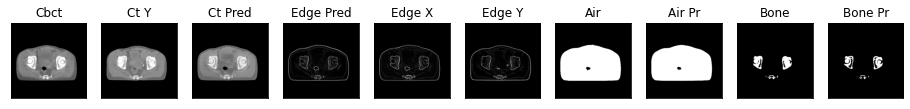

12it [00:04,  2.66it/s]

ssim score = 0.8852680325508118
psnr score = 24.55028533935547
snr score = 14.794370651245117
mae error = 0.020341254770755768
air dice score = 0.9968200836820117
bone dice score = 0.9263285024163486
contour dice score = 0.540772557258606


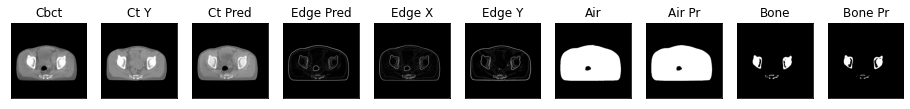

13it [00:05,  2.28it/s]

ssim score = 0.885167121887207
psnr score = 24.59259796142578
snr score = 14.694725036621094
mae error = 0.019484732300043106
air dice score = 0.9966026587887776
bone dice score = 0.8954983922843582
contour dice score = 0.5558987259864807


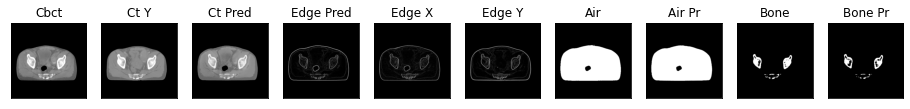

14it [00:05,  2.40it/s]

ssim score = 0.8842884302139282
psnr score = 24.655879974365234
snr score = 14.672347068786621
mae error = 0.019360549747943878
air dice score = 0.996490707265618
bone dice score = 0.8945147679339731
contour dice score = 0.6308642029762268


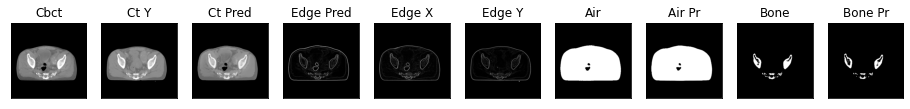

15it [00:06,  2.49it/s]

ssim score = 0.8765940070152283
psnr score = 24.37051010131836
snr score = 14.41046142578125
mae error = 0.020449595525860786
air dice score = 0.9958943405884467
bone dice score = 0.901149425288693
contour dice score = 0.6900438070297241


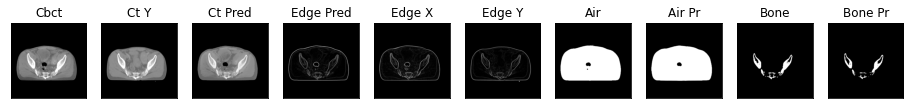

16it [00:06,  2.56it/s]

ssim score = 0.8724747896194458
psnr score = 23.468856811523438
snr score = 13.506264686584473
mae error = 0.022685006260871887
air dice score = 0.9956183898122214
bone dice score = 0.8897790412212201
contour dice score = 0.6616352200508118


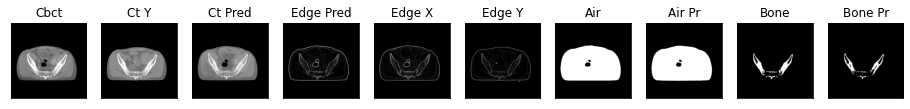

17it [00:06,  2.60it/s]

ssim score = 0.8679894804954529
psnr score = 23.12462615966797
snr score = 13.060274124145508
mae error = 0.023354103788733482
air dice score = 0.9943537311155257
bone dice score = 0.8655126498020571
contour dice score = 0.6637716889381409


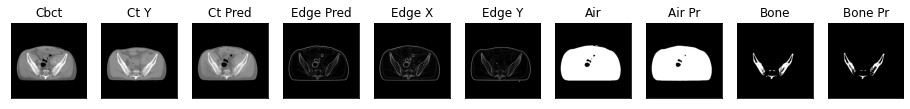

18it [00:07,  2.64it/s]

ssim score = 0.865725576877594
psnr score = 22.94330596923828
snr score = 12.828269958496094
mae error = 0.023800844326615334
air dice score = 0.9934617578656441
bone dice score = 0.8526720594105202
contour dice score = 0.6505101919174194


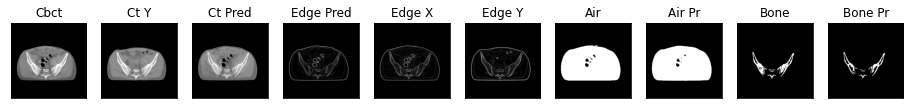

19it [00:07,  2.65it/s]

ssim score = 0.867818295955658
psnr score = 22.972549438476562
snr score = 12.845206260681152
mae error = 0.02392561361193657
air dice score = 0.994375006906923
bone dice score = 0.8720930232575433
contour dice score = 0.6163601875305176


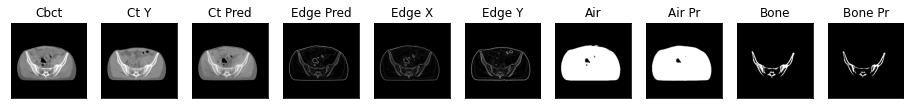

20it [00:07,  2.68it/s]

ssim score = 0.8645705580711365
psnr score = 22.846118927001953
snr score = 12.65392780303955
mae error = 0.02392483502626419
air dice score = 0.9952586543503293
bone dice score = 0.8632795141480776
contour dice score = 0.5782051086425781


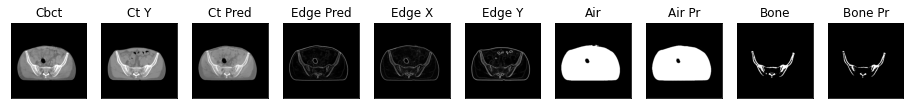

21it [00:08,  2.69it/s]

ssim score = 0.8659060001373291
psnr score = 23.120742797851562
snr score = 12.869120597839355
mae error = 0.022660277783870697
air dice score = 0.9932123904726721
bone dice score = 0.8794367006771169
contour dice score = 0.5216268301010132


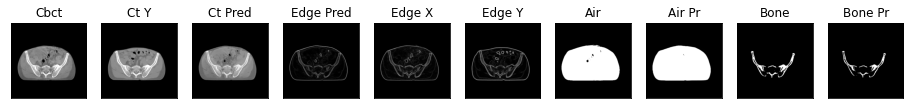

22it [00:08,  2.69it/s]

ssim score = 0.8687652945518494
psnr score = 23.080699920654297
snr score = 12.795652389526367
mae error = 0.023046394810080528
air dice score = 0.9942998591997158
bone dice score = 0.854299142938149
contour dice score = 0.5688311457633972


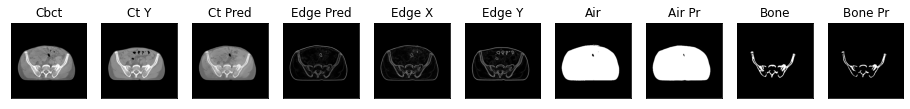

23it [00:09,  2.31it/s]

ssim score = 0.8675147294998169
psnr score = 23.0508975982666
snr score = 12.717284202575684
mae error = 0.023370927199721336
air dice score = 0.9945409087781332
bone dice score = 0.8399246704352983
contour dice score = 0.5890138745307922


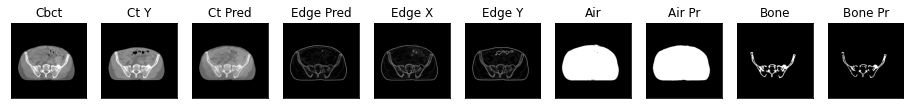

24it [00:09,  2.41it/s]

ssim score = 0.8644718527793884
psnr score = 22.79071617126465
snr score = 12.360100746154785
mae error = 0.023854808881878853
air dice score = 0.9944613809313322
bone dice score = 0.8355416991447708
contour dice score = 0.5127516984939575


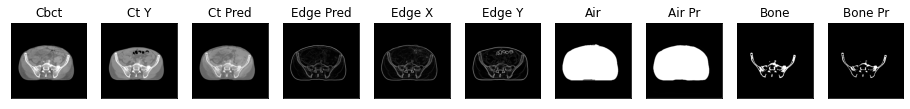

25it [00:10,  2.50it/s]

ssim score = 0.8674747943878174
psnr score = 22.973796844482422
snr score = 12.460450172424316
mae error = 0.023595469072461128
air dice score = 0.993818795616107
bone dice score = 0.8173617466359346
contour dice score = 0.5836734771728516


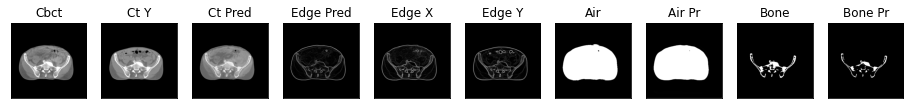

26it [00:10,  2.57it/s]

ssim score = 0.8675816059112549
psnr score = 23.05948257446289
snr score = 12.454949378967285
mae error = 0.023454539477825165
air dice score = 0.9932558647291511
bone dice score = 0.8213920163789484
contour dice score = 0.6304044723510742


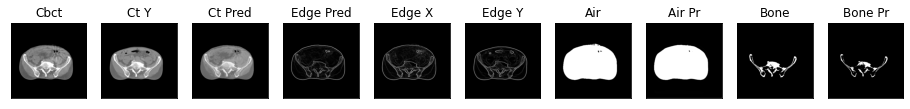

27it [00:10,  2.61it/s]

ssim score = 0.8686450719833374
psnr score = 22.856201171875
snr score = 12.210561752319336
mae error = 0.02340812236070633
air dice score = 0.9930308877936147
bone dice score = 0.8304900181508712
contour dice score = 0.6944248676300049


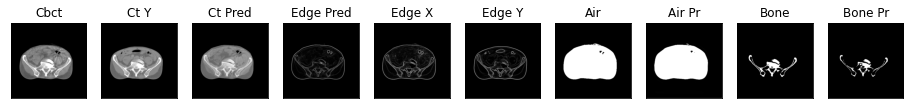

28it [00:11,  2.65it/s]

ssim score = 0.8427306413650513
psnr score = 23.101028442382812
snr score = 14.473185539245605
mae error = 0.02761388197541237
air dice score = 0.9958011816143801
bone dice score = 0.921764705884654
contour dice score = 0.3707483112812042


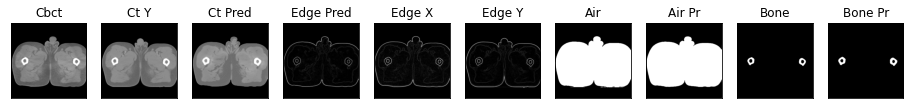

29it [00:11,  2.66it/s]

ssim score = 0.8502414226531982
psnr score = 23.713748931884766
snr score = 15.125164031982422
mae error = 0.026279941201210022
air dice score = 0.9950242651434772
bone dice score = 0.9303358312536681
contour dice score = 0.35979729890823364


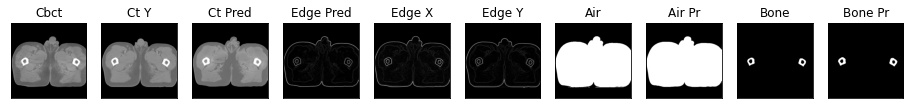

30it [00:11,  2.67it/s]

ssim score = 0.8579884767532349
psnr score = 24.338024139404297
snr score = 15.836886405944824
mae error = 0.024939971044659615
air dice score = 0.9951548911221789
bone dice score = 0.9333037890553223
contour dice score = 0.3297777771949768


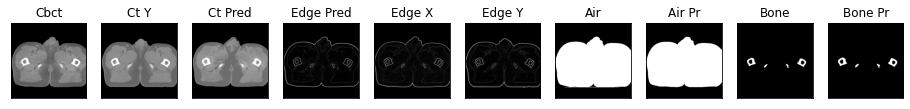

31it [00:12,  2.68it/s]

ssim score = 0.8654128909111023
psnr score = 25.051040649414062
snr score = 16.712461471557617
mae error = 0.023242278024554253
air dice score = 0.9961646358827723
bone dice score = 0.9381362568529658
contour dice score = 0.30882352590560913


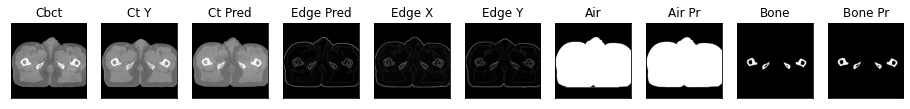

32it [00:12,  2.70it/s]

ssim score = 0.8690606951713562
psnr score = 25.542898178100586
snr score = 17.332460403442383
mae error = 0.022049348801374435
air dice score = 0.9959997345223538
bone dice score = 0.9354750884844069
contour dice score = 0.2999071478843689


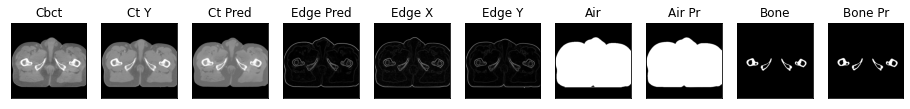

33it [00:13,  2.30it/s]

ssim score = 0.8710176348686218
psnr score = 25.88513946533203
snr score = 17.77794075012207
mae error = 0.02201465703547001
air dice score = 0.9961772873165301
bone dice score = 0.9358835558771095
contour dice score = 0.3133426308631897


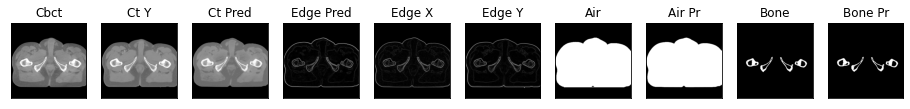

34it [00:13,  2.39it/s]

ssim score = 0.8733182549476624
psnr score = 26.27729034423828
snr score = 18.237192153930664
mae error = 0.021759508177638054
air dice score = 0.9960060597713838
bone dice score = 0.9238329238337745
contour dice score = 0.2793503403663635


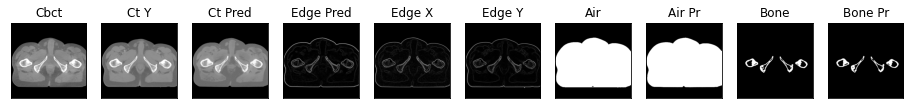

35it [00:13,  2.48it/s]

ssim score = 0.8735541105270386
psnr score = 26.309513092041016
snr score = 18.259525299072266
mae error = 0.022029154002666473
air dice score = 0.9961556829035362
bone dice score = 0.9345257106362768
contour dice score = 0.30847615003585815


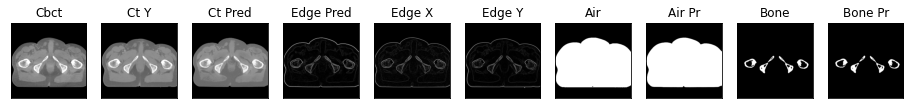

36it [00:14,  2.54it/s]

ssim score = 0.8762901425361633
psnr score = 26.44918441772461
snr score = 18.38553237915039
mae error = 0.021750841289758682
air dice score = 0.996133982236574
bone dice score = 0.9337839264976895
contour dice score = 0.29694727063179016


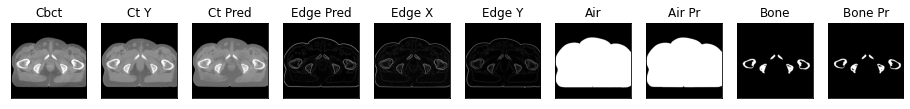

37it [00:14,  2.59it/s]

ssim score = 0.8805721998214722
psnr score = 26.85321807861328
snr score = 18.80156707763672
mae error = 0.02127014845609665
air dice score = 0.9962457683085751
bone dice score = 0.9342676009349987
contour dice score = 0.2847866415977478


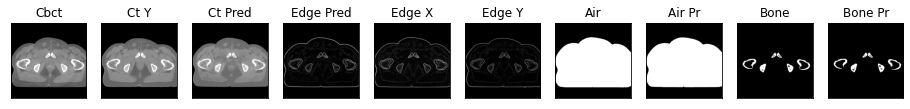

38it [00:15,  2.62it/s]

ssim score = 0.8817252516746521
psnr score = 26.993507385253906
snr score = 18.98094367980957
mae error = 0.020914524793624878
air dice score = 0.9962053173139855
bone dice score = 0.9273654390943074
contour dice score = 0.278268963098526


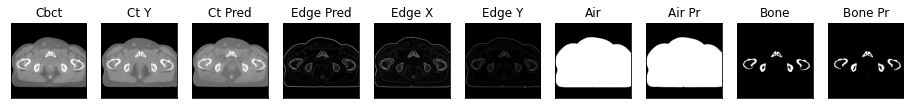

39it [00:15,  2.64it/s]

ssim score = 0.8782618045806885
psnr score = 26.742841720581055
snr score = 18.871566772460938
mae error = 0.022450679913163185
air dice score = 0.9963301988354202
bone dice score = 0.9228010758051319
contour dice score = 0.2516309320926666


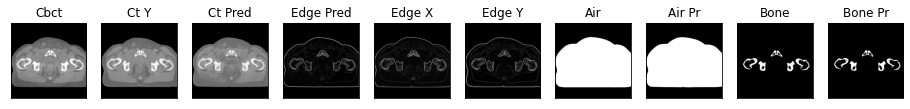

40it [00:15,  2.65it/s]

ssim score = 0.8767931461334229
psnr score = 26.508819580078125
snr score = 18.73223114013672
mae error = 0.023462781682610512
air dice score = 0.996104638696307
bone dice score = 0.906933692360258
contour dice score = 0.25269070267677307


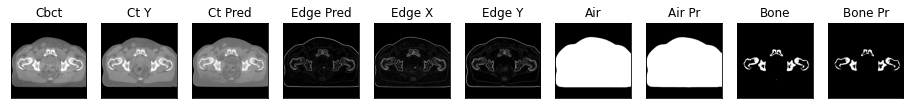

41it [00:16,  2.66it/s]

ssim score = 0.8668622970581055
psnr score = 25.958749771118164
snr score = 18.148115158081055
mae error = 0.024164855480194092
air dice score = 0.9962123022511135
bone dice score = 0.8835267596235825
contour dice score = 0.2720450162887573


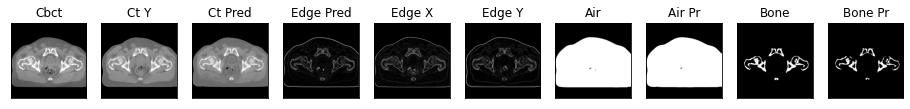

42it [00:16,  2.67it/s]

ssim score = 0.8640393614768982
psnr score = 25.21940040588379
snr score = 17.48094940185547
mae error = 0.025259077548980713
air dice score = 0.9958242458107297
bone dice score = 0.8081514713724572
contour dice score = 0.2624647319316864


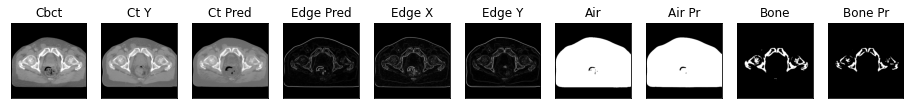

43it [00:17,  2.28it/s]

ssim score = 0.8662301301956177
psnr score = 25.278980255126953
snr score = 17.404436111450195
mae error = 0.024247435852885246
air dice score = 0.9959538095094546
bone dice score = 0.8571962966439989
contour dice score = 0.2801886796951294


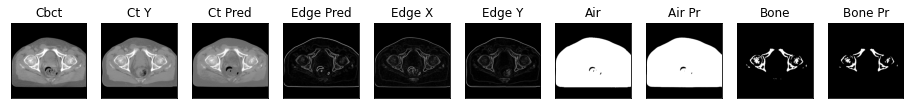

44it [00:17,  2.37it/s]

ssim score = 0.8689122796058655
psnr score = 25.369882583618164
snr score = 17.316776275634766
mae error = 0.02302613854408264
air dice score = 0.9963410725193401
bone dice score = 0.8887136520464395
contour dice score = 0.28977271914482117


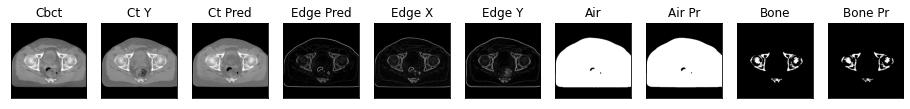

45it [00:17,  2.46it/s]

ssim score = 0.8679070472717285
psnr score = 25.703144073486328
snr score = 17.5594482421875
mae error = 0.022504575550556183
air dice score = 0.9966689681068858
bone dice score = 0.8851306830673716
contour dice score = 0.294536828994751


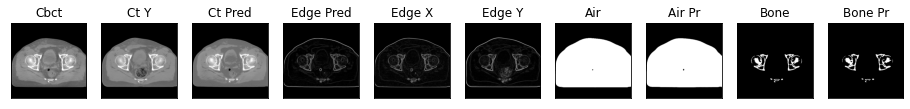

46it [00:18,  2.52it/s]

ssim score = 0.868287205696106
psnr score = 25.780094146728516
snr score = 17.652090072631836
mae error = 0.021997282281517982
air dice score = 0.9970503268967632
bone dice score = 0.907299875571264
contour dice score = 0.31794384121894836


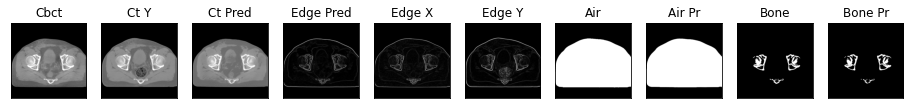

47it [00:18,  2.57it/s]

ssim score = 0.8602046966552734
psnr score = 25.609262466430664
snr score = 17.491291046142578
mae error = 0.022641489282250404
air dice score = 0.9970537537133723
bone dice score = 0.9019495958164342
contour dice score = 0.32983794808387756


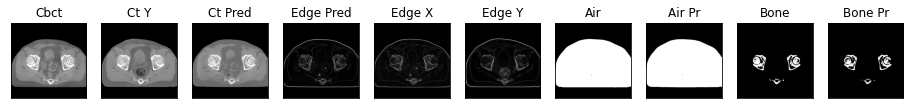

48it [00:19,  2.57it/s]

ssim score = 0.8684605360031128
psnr score = 26.00515365600586
snr score = 17.948776245117188
mae error = 0.022077560424804688
air dice score = 0.9972960876043108
bone dice score = 0.9036800600835179
contour dice score = 0.349690318107605


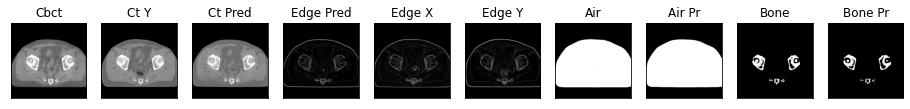

49it [00:19,  2.60it/s]

ssim score = 0.867697536945343
psnr score = 26.508100509643555
snr score = 18.52180290222168
mae error = 0.021515177562832832
air dice score = 0.9970134578750095
bone dice score = 0.9312785592694984
contour dice score = 0.34840551018714905


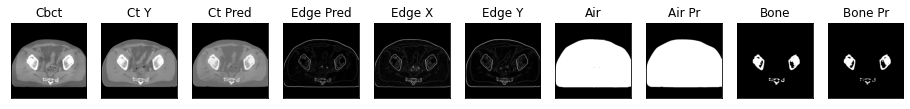

50it [00:19,  2.60it/s]

ssim score = 0.8743812441825867
psnr score = 26.28348159790039
snr score = 18.178075790405273
mae error = 0.021747581660747528
air dice score = 0.9970257481718202
bone dice score = 0.9394739415279214
contour dice score = 0.34174203872680664


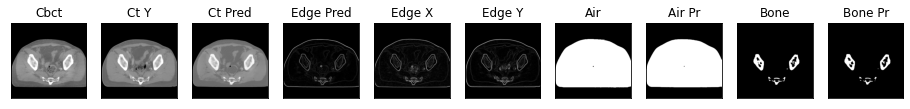

51it [00:20,  2.62it/s]

ssim score = 0.8676862716674805
psnr score = 25.7960147857666
snr score = 17.772239685058594
mae error = 0.02288174442946911
air dice score = 0.9965067378825573
bone dice score = 0.9283898676489755
contour dice score = 0.3287147581577301


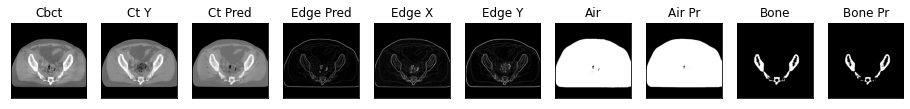

52it [00:20,  2.64it/s]

ssim score = 0.869733452796936
psnr score = 25.847227096557617
snr score = 17.903596878051758
mae error = 0.023602718487381935
air dice score = 0.9963172439994386
bone dice score = 0.8956351004387885
contour dice score = 0.2936660349369049


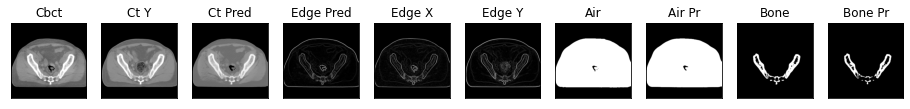

53it [00:21,  2.27it/s]

ssim score = 0.8541259169578552
psnr score = 25.174518585205078
snr score = 17.252443313598633
mae error = 0.025170354172587395
air dice score = 0.9963982364200082
bone dice score = 0.8831586196351431
contour dice score = 0.26602408289909363


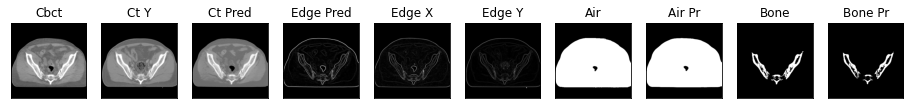

54it [00:21,  2.37it/s]

ssim score = 0.853649377822876
psnr score = 25.6500244140625
snr score = 17.740493774414062
mae error = 0.025080595165491104
air dice score = 0.9960929442455887
bone dice score = 0.8998617723859633
contour dice score = 0.24915824830532074


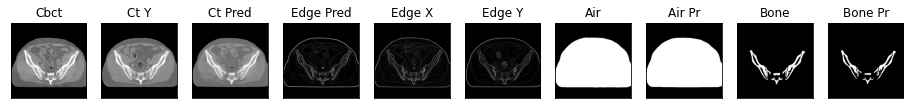

55it [00:21,  2.44it/s]

ssim score = 0.801459789276123
psnr score = 20.805986404418945
snr score = 10.686195373535156
mae error = 0.03371301665902138
air dice score = 0.9963301933122047
bone dice score = 0.9301719645666969
contour dice score = 0.6312879920005798


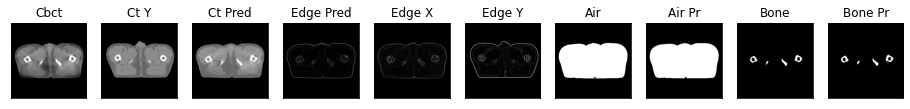

56it [00:22,  2.50it/s]

ssim score = 0.7921334505081177
psnr score = 20.59189224243164
snr score = 10.685081481933594
mae error = 0.0350361205637455
air dice score = 0.9971246516746267
bone dice score = 0.9255097794439137
contour dice score = 0.6065934300422668


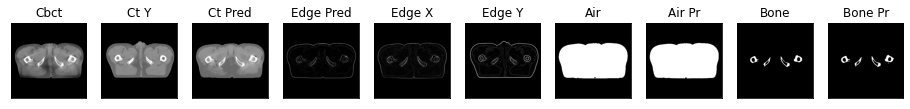

57it [00:22,  2.56it/s]

ssim score = 0.7889257073402405
psnr score = 20.600759506225586
snr score = 10.825088500976562
mae error = 0.03509595990180969
air dice score = 0.9968744481723496
bone dice score = 0.9080594679204214
contour dice score = 0.5859802961349487


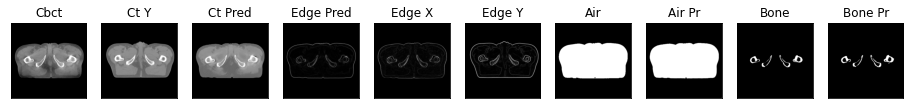

58it [00:22,  2.60it/s]

ssim score = 0.7930834889411926
psnr score = 20.950687408447266
snr score = 11.245414733886719
mae error = 0.033596888184547424
air dice score = 0.9966254218222752
bone dice score = 0.899923896501143
contour dice score = 0.5325314402580261


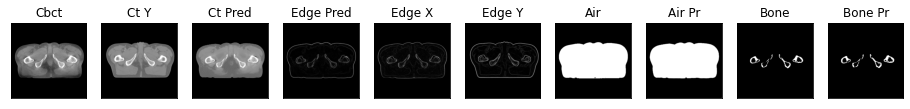

59it [00:23,  2.64it/s]

ssim score = 0.7921810746192932
psnr score = 21.036991119384766
snr score = 11.379289627075195
mae error = 0.033308010548353195
air dice score = 0.9970057783225381
bone dice score = 0.9022304832731928
contour dice score = 0.5282608866691589


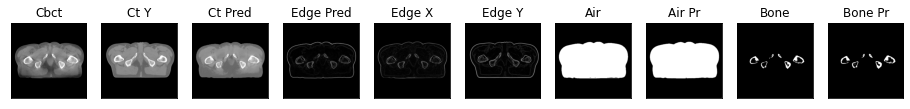

60it [00:23,  2.64it/s]

ssim score = 0.7919060587882996
psnr score = 21.15654754638672
snr score = 11.5044584274292
mae error = 0.03299684450030327
air dice score = 0.9967099234642702
bone dice score = 0.916209293817852
contour dice score = 0.5474801063537598


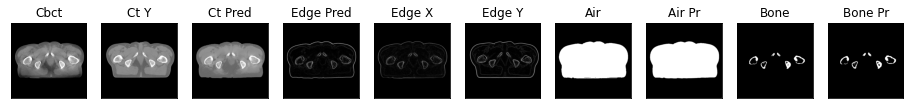

61it [00:24,  2.66it/s]

ssim score = 0.7931362986564636
psnr score = 21.186870574951172
snr score = 11.528282165527344
mae error = 0.03299126774072647
air dice score = 0.9962235912429116
bone dice score = 0.9216300940453322
contour dice score = 0.5504782199859619


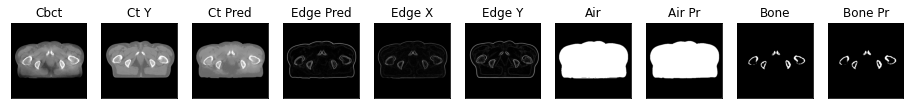

62it [00:24,  2.69it/s]

ssim score = 0.7915332317352295
psnr score = 21.045673370361328
snr score = 11.401193618774414
mae error = 0.03356770798563957
air dice score = 0.9964024099518908
bone dice score = 0.933189267064052
contour dice score = 0.5582627058029175


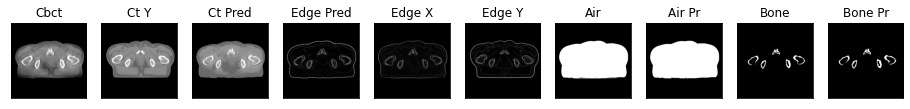

63it [00:25,  2.30it/s]

ssim score = 0.7921805381774902
psnr score = 20.957433700561523
snr score = 11.370962142944336
mae error = 0.034513600170612335
air dice score = 0.99632684177698
bone dice score = 0.9208306294626731
contour dice score = 0.6122666597366333


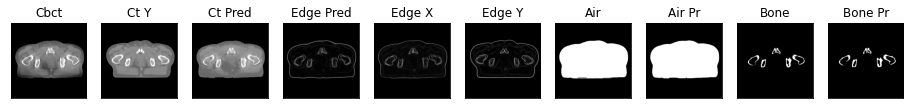

64it [00:25,  2.42it/s]

ssim score = 0.7824579477310181
psnr score = 20.79249382019043
snr score = 11.304580688476562
mae error = 0.03596347197890282
air dice score = 0.9957240223560242
bone dice score = 0.9025609940914902
contour dice score = 0.5815303325653076


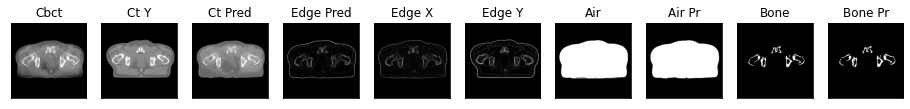

65it [00:25,  2.49it/s]

ssim score = 0.771668553352356
psnr score = 20.630647659301758
snr score = 11.178564071655273
mae error = 0.037261202931404114
air dice score = 0.9958957025591537
bone dice score = 0.9081064821791531
contour dice score = 0.5525751113891602


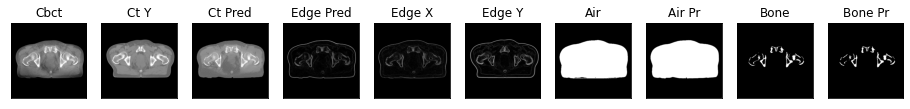

66it [00:26,  2.55it/s]

ssim score = 0.7641737461090088
psnr score = 20.563610076904297
snr score = 11.144231796264648
mae error = 0.03742054104804993
air dice score = 0.9961666020588394
bone dice score = 0.8755198225689559
contour dice score = 0.5671482086181641


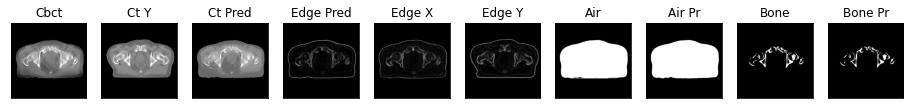

67it [00:26,  2.60it/s]

ssim score = 0.7623386979103088
psnr score = 20.704978942871094
snr score = 11.40241813659668
mae error = 0.03717043995857239
air dice score = 0.9963308757665573
bone dice score = 0.8971390552242563
contour dice score = 0.6020031571388245


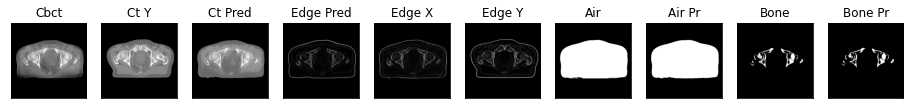

68it [00:26,  2.64it/s]

ssim score = 0.7634826898574829
psnr score = 20.763769149780273
snr score = 11.445220947265625
mae error = 0.0370379239320755
air dice score = 0.9970728011571071
bone dice score = 0.8939844302916633
contour dice score = 0.6057640314102173


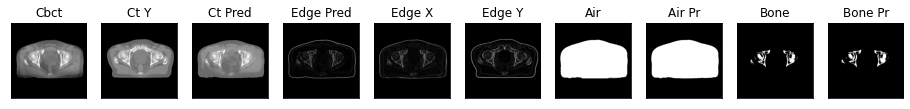

69it [00:27,  2.66it/s]

ssim score = 0.776418149471283
psnr score = 21.169540405273438
snr score = 11.651830673217773
mae error = 0.03488748520612717
air dice score = 0.9968428206429661
bone dice score = 0.9093061103726985
contour dice score = 0.5815450549125671


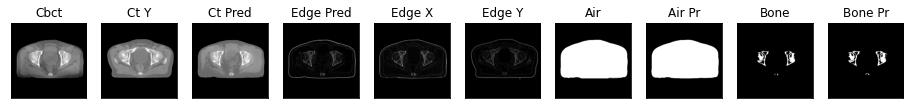

70it [00:27,  2.67it/s]

ssim score = 0.7920549511909485
psnr score = 21.661785125732422
snr score = 11.973681449890137
mae error = 0.0329367071390152
air dice score = 0.996719396781233
bone dice score = 0.9342251950956769
contour dice score = 0.6196880340576172


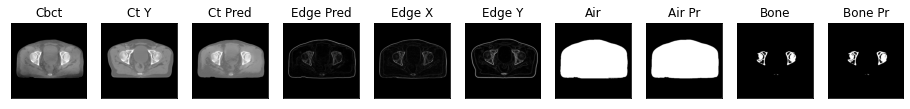

71it [00:27,  2.69it/s]

ssim score = 0.8002123236656189
psnr score = 22.018970489501953
snr score = 12.345036506652832
mae error = 0.03170153126120567
air dice score = 0.9965893120351039
bone dice score = 0.9351308061941387
contour dice score = 0.6200640201568604


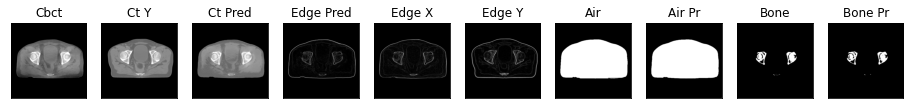

72it [00:28,  2.71it/s]

ssim score = 0.8079153299331665
psnr score = 22.321035385131836
snr score = 12.728928565979004
mae error = 0.03070058487355709
air dice score = 0.9967350985453268
bone dice score = 0.9374322860246826
contour dice score = 0.6475054025650024


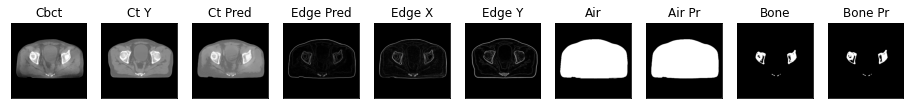

73it [00:28,  2.32it/s]

ssim score = 0.8078234195709229
psnr score = 22.319438934326172
snr score = 12.819501876831055
mae error = 0.031108204275369644
air dice score = 0.9968719902494764
bone dice score = 0.9323707087088202
contour dice score = 0.5981308221817017


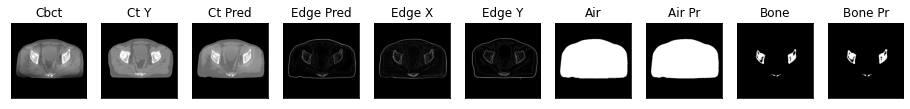

74it [00:29,  2.43it/s]

ssim score = 0.8036722540855408
psnr score = 22.57231903076172
snr score = 13.00895881652832
mae error = 0.030294090509414673
air dice score = 0.9965601882129145
bone dice score = 0.9439071566740183
contour dice score = 0.606970489025116


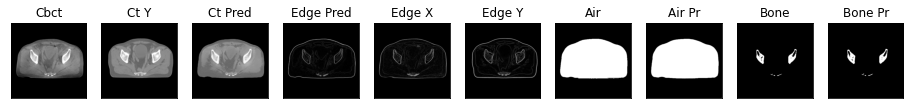

75it [00:29,  2.50it/s]

ssim score = 0.8099172115325928
psnr score = 22.738616943359375
snr score = 13.138861656188965
mae error = 0.029300332069396973
air dice score = 0.9965783954967299
bone dice score = 0.9429366736266016
contour dice score = 0.5835995674133301


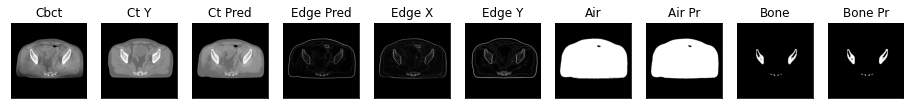

76it [00:30,  2.55it/s]

ssim score = 0.8064208030700684
psnr score = 22.47842788696289
snr score = 12.916417121887207
mae error = 0.030546294525265694
air dice score = 0.9966708564052071
bone dice score = 0.9263704184248075
contour dice score = 0.5718832612037659


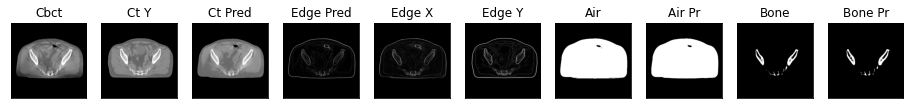

77it [00:30,  2.58it/s]

ssim score = 0.802621603012085
psnr score = 22.4342041015625
snr score = 13.00269889831543
mae error = 0.030845612287521362
air dice score = 0.9964394666847981
bone dice score = 0.9198031268106571
contour dice score = 0.6007482409477234


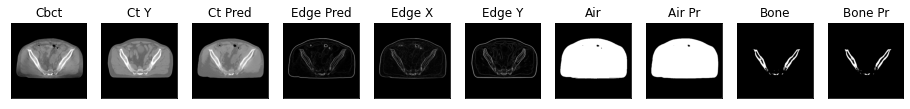

78it [00:30,  2.61it/s]

ssim score = 0.8052285313606262
psnr score = 22.349660873413086
snr score = 12.935903549194336
mae error = 0.030771169811487198
air dice score = 0.9962705355237924
bone dice score = 0.9065520945234532
contour dice score = 0.568206250667572


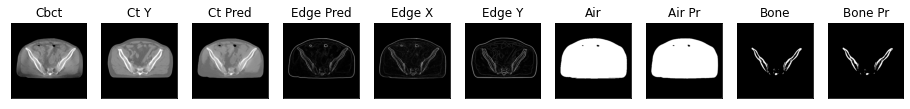

79it [00:31,  2.62it/s]

ssim score = 0.808068573474884
psnr score = 22.884634017944336
snr score = 13.459609985351562
mae error = 0.02919437177479267
air dice score = 0.9963925520337983
bone dice score = 0.9040013173076897
contour dice score = 0.5669546723365784


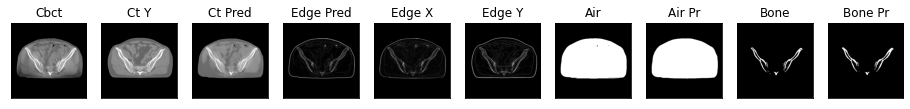

80it [00:31,  2.63it/s]

ssim score = 0.8113572001457214
psnr score = 22.98263168334961
snr score = 13.556863784790039
mae error = 0.028676755726337433
air dice score = 0.9967737217485596
bone dice score = 0.9066154092598652
contour dice score = 0.5620915293693542


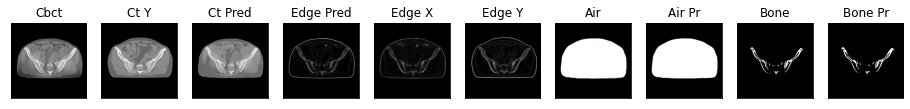

81it [00:31,  2.63it/s]

ssim score = 0.8512527942657471
psnr score = 23.662607192993164
snr score = 14.096744537353516
mae error = 0.023724287748336792
air dice score = 0.9957209450575755
bone dice score = 0.8763661202228017
contour dice score = 0.5095744729042053


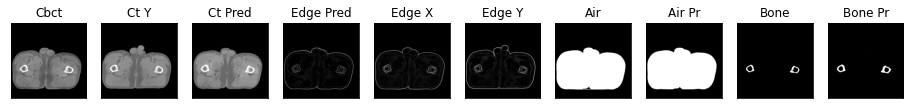

82it [00:32,  2.65it/s]

ssim score = 0.8538696765899658
psnr score = 23.9581298828125
snr score = 14.456657409667969
mae error = 0.022883260622620583
air dice score = 0.9960180178753821
bone dice score = 0.8702147525717331
contour dice score = 0.4612954258918762


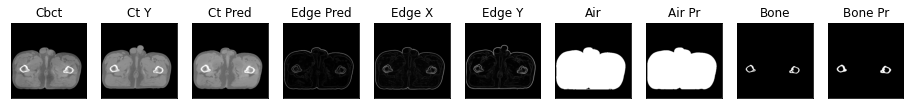

83it [00:32,  2.28it/s]

ssim score = 0.862069308757782
psnr score = 25.399429321289062
snr score = 16.03717041015625
mae error = 0.02086019515991211
air dice score = 0.9962832841683584
bone dice score = 0.9072555205066823
contour dice score = 0.5058524012565613


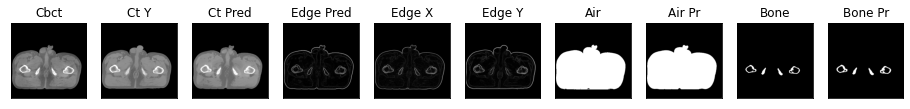

84it [00:33,  2.38it/s]

ssim score = 0.8643291592597961
psnr score = 25.61374282836914
snr score = 16.372970581054688
mae error = 0.020282091572880745
air dice score = 0.9968385971469532
bone dice score = 0.889644142345269
contour dice score = 0.5174897313117981


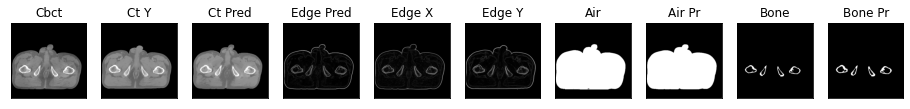

85it [00:33,  2.45it/s]

ssim score = 0.8609881401062012
psnr score = 25.478172302246094
snr score = 16.261573791503906
mae error = 0.02049918659031391
air dice score = 0.9971490938468611
bone dice score = 0.8764044943845474
contour dice score = 0.5552672743797302


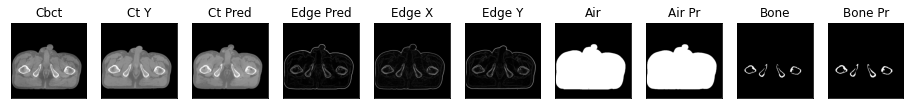

86it [00:34,  2.50it/s]

ssim score = 0.8590995073318481
psnr score = 25.258563995361328
snr score = 16.037572860717773
mae error = 0.021075142547488213
air dice score = 0.997384454189144
bone dice score = 0.8735845554135218
contour dice score = 0.5368146300315857


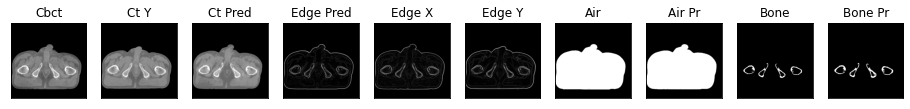

87it [00:34,  2.54it/s]

ssim score = 0.8613681793212891
psnr score = 24.985485076904297
snr score = 15.770746231079102
mae error = 0.0213557668030262
air dice score = 0.9972239454094314
bone dice score = 0.8835341365483108
contour dice score = 0.5325630307197571


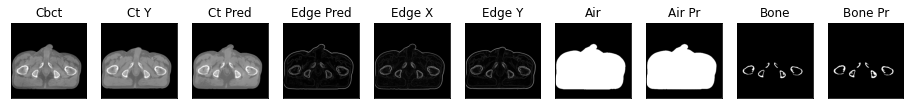

88it [00:34,  2.58it/s]

ssim score = 0.859177827835083
psnr score = 24.720413208007812
snr score = 15.484118461608887
mae error = 0.02173205092549324
air dice score = 0.9973528338650975
bone dice score = 0.8866850321416587
contour dice score = 0.5395152568817139


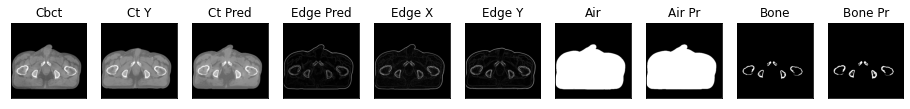

89it [00:35,  2.60it/s]

ssim score = 0.8595641851425171
psnr score = 24.680004119873047
snr score = 15.46061897277832
mae error = 0.02173013985157013
air dice score = 0.9971820899240276
bone dice score = 0.9091231178049757
contour dice score = 0.5140434503555298


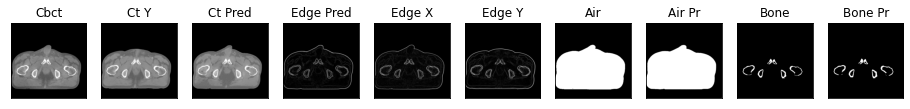

90it [00:35,  2.62it/s]

ssim score = 0.8593206405639648
psnr score = 25.040063858032227
snr score = 15.88927173614502
mae error = 0.021050287410616875
air dice score = 0.9976951144238976
bone dice score = 0.9158084028132122
contour dice score = 0.589428722858429


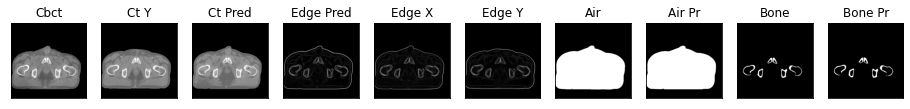

91it [00:35,  2.62it/s]

ssim score = 0.8600759506225586
psnr score = 25.479097366333008
snr score = 16.409664154052734
mae error = 0.020511172711849213
air dice score = 0.9979923143282895
bone dice score = 0.9117513953852504
contour dice score = 0.5738850235939026


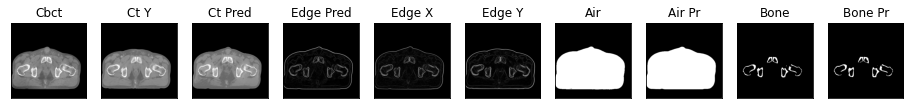

92it [00:36,  2.64it/s]

ssim score = 0.858634889125824
psnr score = 25.70386505126953
snr score = 16.685134887695312
mae error = 0.020608915016055107
air dice score = 0.9982048940257627
bone dice score = 0.9071839080473105
contour dice score = 0.6387096643447876


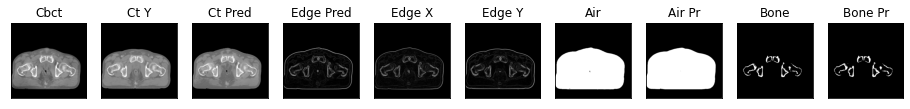

93it [00:36,  2.27it/s]

ssim score = 0.8599852919578552
psnr score = 26.021738052368164
snr score = 17.11927604675293
mae error = 0.020330797880887985
air dice score = 0.9983890582308081
bone dice score = 0.871234412219823
contour dice score = 0.6336740255355835


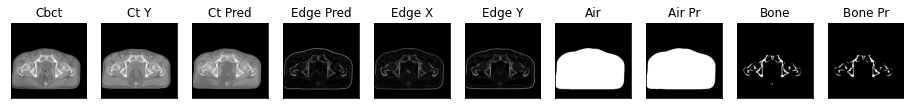

94it [00:37,  2.38it/s]

ssim score = 0.8629454374313354
psnr score = 25.780315399169922
snr score = 16.839616775512695
mae error = 0.02029367722570896
air dice score = 0.9980791821443328
bone dice score = 0.8811086797975038
contour dice score = 0.6246634125709534


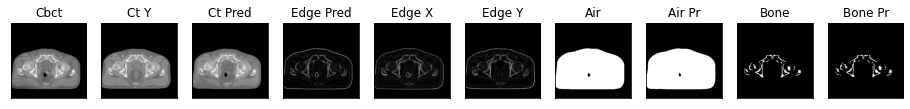

95it [00:37,  2.45it/s]

ssim score = 0.8553413152694702
psnr score = 24.916397094726562
snr score = 15.880029678344727
mae error = 0.021367572247982025
air dice score = 0.9976237528703004
bone dice score = 0.8844857797562409
contour dice score = 0.5655693411827087


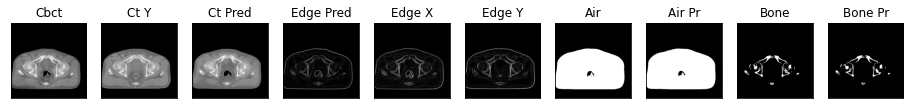

96it [00:37,  2.50it/s]

ssim score = 0.8597239851951599
psnr score = 24.758283615112305
snr score = 15.562158584594727
mae error = 0.021090511232614517
air dice score = 0.9971013092419947
bone dice score = 0.8812344139669384
contour dice score = 0.5800865888595581


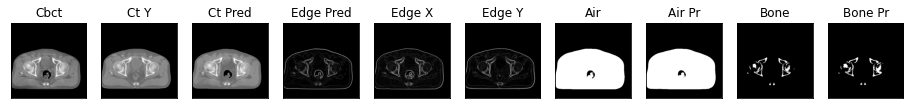

97it [00:38,  2.55it/s]

ssim score = 0.8587378859519958
psnr score = 24.23917007446289
snr score = 14.926619529724121
mae error = 0.0220449510961771
air dice score = 0.9970279535220811
bone dice score = 0.8809714011841993
contour dice score = 0.550787627696991


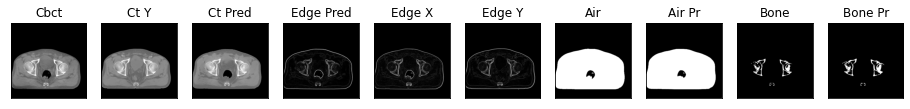

98it [00:38,  2.58it/s]

ssim score = 0.8528265953063965
psnr score = 24.121265411376953
snr score = 14.76362133026123
mae error = 0.022440070286393166
air dice score = 0.9972953036636364
bone dice score = 0.9013785790046753
contour dice score = 0.580152690410614


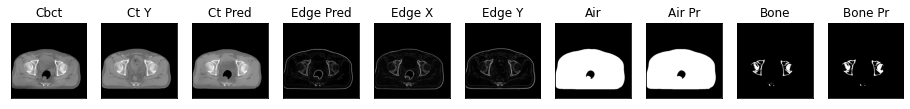

99it [00:39,  2.60it/s]

ssim score = 0.8504400849342346
psnr score = 23.597824096679688
snr score = 14.24685287475586
mae error = 0.023365983739495277
air dice score = 0.9972827648483378
bone dice score = 0.9137603043767635
contour dice score = 0.5049180388450623


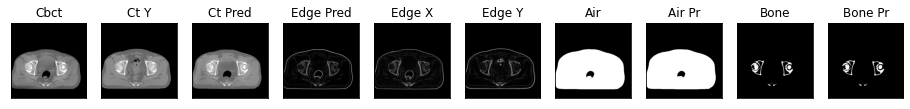

100it [00:39,  2.62it/s]

ssim score = 0.8524003028869629
psnr score = 23.36082649230957
snr score = 14.039958953857422
mae error = 0.023858418688178062
air dice score = 0.997714116563612
bone dice score = 0.9352692075024914
contour dice score = 0.5194095373153687


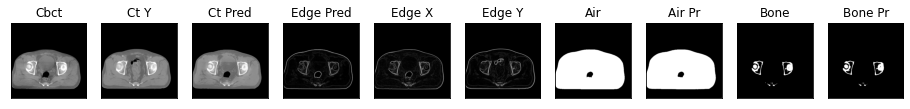

101it [00:39,  2.62it/s]

ssim score = 0.8621662259101868
psnr score = 24.106704711914062
snr score = 14.743250846862793
mae error = 0.0217842198908329
air dice score = 0.9972002594481003
bone dice score = 0.9263123033627039
contour dice score = 0.4950712025165558


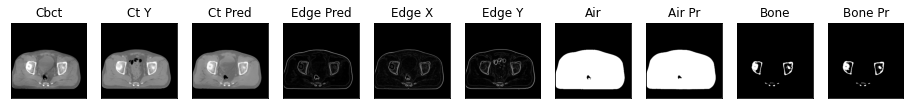

102it [00:40,  2.64it/s]

ssim score = 0.8631932735443115
psnr score = 24.308053970336914
snr score = 14.85439682006836
mae error = 0.0210496187210083
air dice score = 0.996601669471117
bone dice score = 0.9203411359114436
contour dice score = 0.46987950801849365


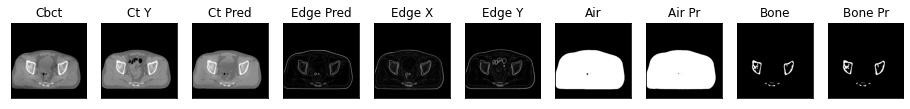

103it [00:40,  2.27it/s]

ssim score = 0.8624183535575867
psnr score = 23.970243453979492
snr score = 14.450860023498535
mae error = 0.02136433869600296
air dice score = 0.9969410293811236
bone dice score = 0.9272727272741047
contour dice score = 0.5137211680412292


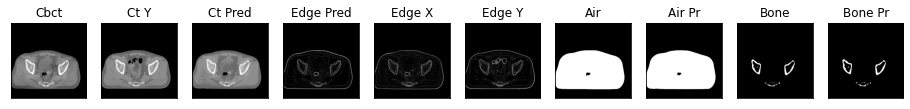

104it [00:41,  2.37it/s]

ssim score = 0.8605989813804626
psnr score = 24.072803497314453
snr score = 14.553117752075195
mae error = 0.021436700597405434
air dice score = 0.9967096427612169
bone dice score = 0.9417328154037876
contour dice score = 0.49504950642585754


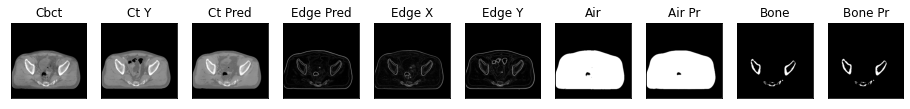

105it [00:41,  2.45it/s]

ssim score = 0.8597915172576904
psnr score = 24.23173713684082
snr score = 14.788217544555664
mae error = 0.02140200324356556
air dice score = 0.9968839438432515
bone dice score = 0.9241281138800835
contour dice score = 0.559602677822113


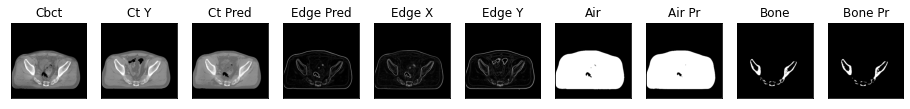

106it [00:41,  2.50it/s]

ssim score = 0.8637897372245789
psnr score = 24.386184692382812
snr score = 14.978245735168457
mae error = 0.020773766562342644
air dice score = 0.9972979653764545
bone dice score = 0.9153090076758408
contour dice score = 0.5433462262153625


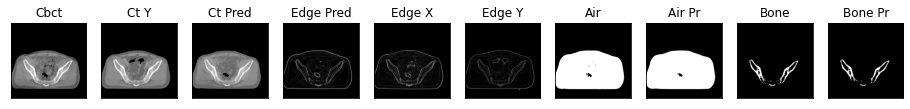

107it [00:42,  2.55it/s]

ssim score = 0.8659040331840515
psnr score = 24.88868522644043
snr score = 15.419049263000488
mae error = 0.019944682717323303
air dice score = 0.9972481075381302
bone dice score = 0.9036802760220862
contour dice score = 0.476137638092041


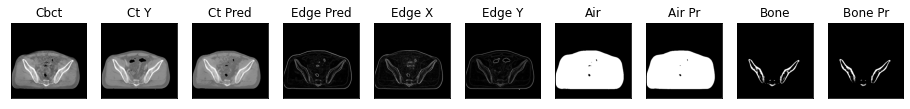

108it [00:42,  2.58it/s]

ssim score = 0.863418698310852
psnr score = 24.704973220825195
snr score = 15.174076080322266
mae error = 0.020394587889313698
air dice score = 0.9969828219692084
bone dice score = 0.8916529297183927
contour dice score = 0.43473389744758606


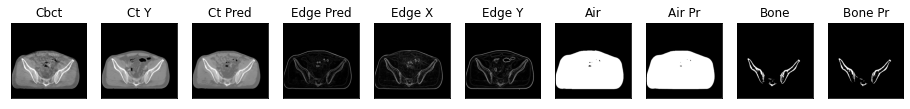

109it [00:43,  2.60it/s]

ssim score = 0.7887637615203857
psnr score = 22.208484649658203
snr score = 13.905792236328125
mae error = 0.033170897513628006
air dice score = 0.996227220956722
bone dice score = 0.9049956684982675
contour dice score = 0.36403700709342957


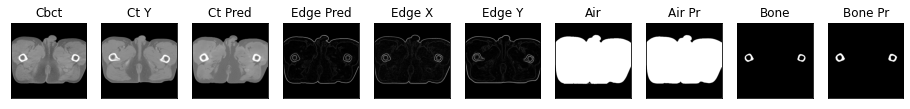

110it [00:43,  2.62it/s]

ssim score = 0.7768568396568298
psnr score = 21.78972625732422
snr score = 13.591325759887695
mae error = 0.03501283749938011
air dice score = 0.9965915791956619
bone dice score = 0.8973029045669787
contour dice score = 0.3660595417022705


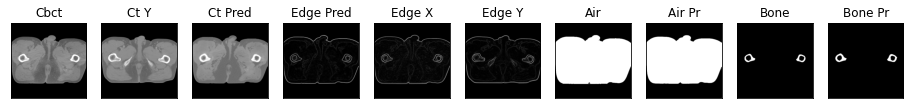

111it [00:43,  2.62it/s]

ssim score = 0.7754541635513306
psnr score = 21.59313201904297
snr score = 13.522686004638672
mae error = 0.03615904226899147
air dice score = 0.9964848755598944
bone dice score = 0.8847262247862345
contour dice score = 0.3497316539287567


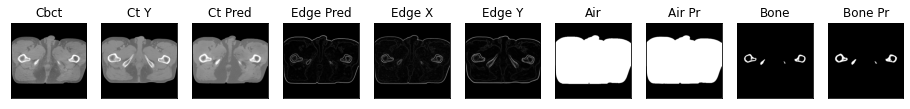

112it [00:44,  2.62it/s]

ssim score = 0.765449583530426
psnr score = 21.3348388671875
snr score = 13.29668140411377
mae error = 0.03648029640316963
air dice score = 0.9962415934236702
bone dice score = 0.9108380592326585
contour dice score = 0.31910112500190735


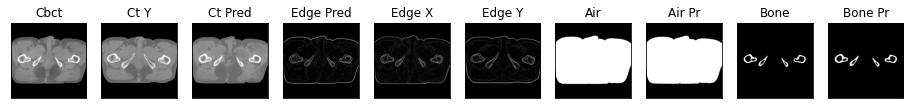

113it [00:44,  2.26it/s]

ssim score = 0.7528533935546875
psnr score = 21.262798309326172
snr score = 13.254880905151367
mae error = 0.03716644272208214
air dice score = 0.9960751741604932
bone dice score = 0.8999540370782909
contour dice score = 0.3179765045642853


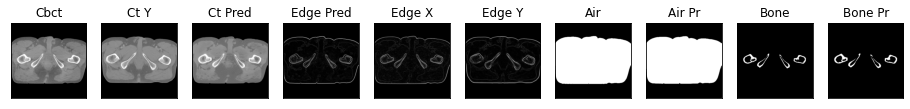

114it [00:45,  2.36it/s]

ssim score = 0.7490426301956177
psnr score = 21.20796012878418
snr score = 13.234458923339844
mae error = 0.0381096675992012
air dice score = 0.9962394398222939
bone dice score = 0.8979231109162186
contour dice score = 0.32459312677383423


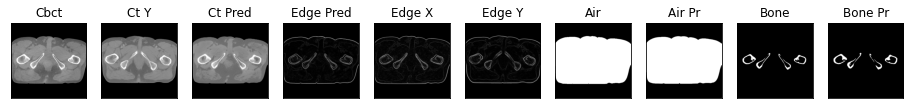

115it [00:45,  2.44it/s]

ssim score = 0.74161696434021
psnr score = 20.93297004699707
snr score = 12.979778289794922
mae error = 0.03914504125714302
air dice score = 0.996161105787382
bone dice score = 0.9027777777790517
contour dice score = 0.3075539469718933


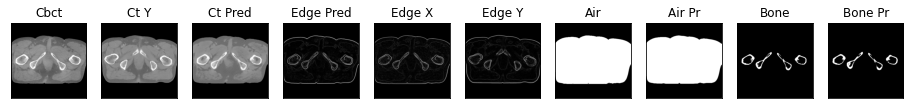

116it [00:45,  2.49it/s]

ssim score = 0.7394365072250366
psnr score = 20.970455169677734
snr score = 13.05633544921875
mae error = 0.03940674662590027
air dice score = 0.9955634942267457
bone dice score = 0.8949161425590288
contour dice score = 0.3436518609523773


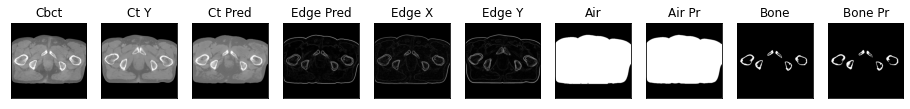

117it [00:46,  2.53it/s]

ssim score = 0.7427656054496765
psnr score = 21.110252380371094
snr score = 13.2448148727417
mae error = 0.03889954462647438
air dice score = 0.9946919288312412
bone dice score = 0.9095785440624575
contour dice score = 0.31986093521118164


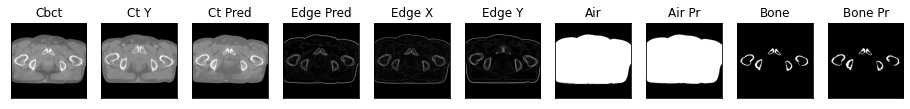

118it [00:46,  2.57it/s]

ssim score = 0.7341446876525879
psnr score = 20.94721221923828
snr score = 13.104386329650879
mae error = 0.04053724184632301
air dice score = 0.9949970724467997
bone dice score = 0.9149956944284046
contour dice score = 0.3068423271179199


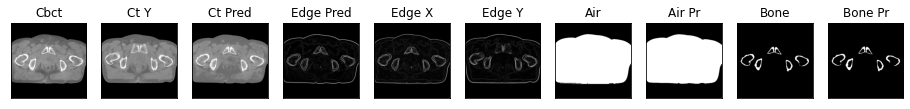

119it [00:47,  2.59it/s]

ssim score = 0.721514105796814
psnr score = 20.87105941772461
snr score = 13.071008682250977
mae error = 0.04214030131697655
air dice score = 0.9955056309758649
bone dice score = 0.9181860682571507
contour dice score = 0.29944702982902527


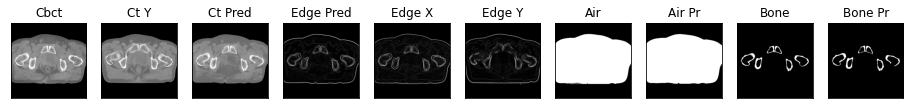

120it [00:47,  2.61it/s]

ssim score = 0.7255892157554626
psnr score = 20.850257873535156
snr score = 13.108545303344727
mae error = 0.04255778342485428
air dice score = 0.9952538854127647
bone dice score = 0.9227968733277353
contour dice score = 0.30776214599609375


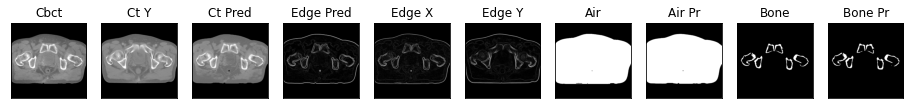

121it [00:47,  2.55it/s]

ssim score = 0.7236191630363464
psnr score = 20.650758743286133
snr score = 12.833677291870117
mae error = 0.044004667550325394
air dice score = 0.9955975567592511
bone dice score = 0.892344737635273
contour dice score = 0.2945736348628998


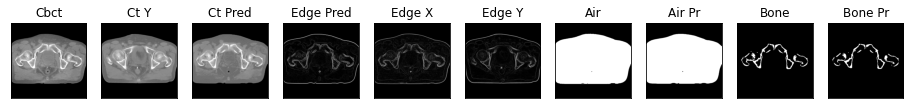

122it [00:48,  2.57it/s]

ssim score = 0.7247786521911621
psnr score = 20.498218536376953
snr score = 12.573917388916016
mae error = 0.04506571218371391
air dice score = 0.9955350712948319
bone dice score = 0.8817827520747299
contour dice score = 0.28832951188087463


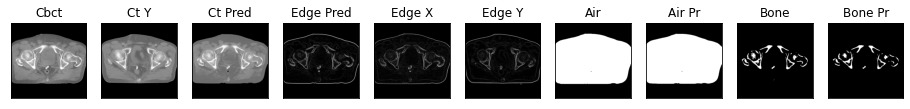

123it [00:48,  2.21it/s]

ssim score = 0.7353740930557251
psnr score = 20.7923526763916
snr score = 12.744965553283691
mae error = 0.04285300523042679
air dice score = 0.9960333018149973
bone dice score = 0.8503017710512486
contour dice score = 0.2984389364719391


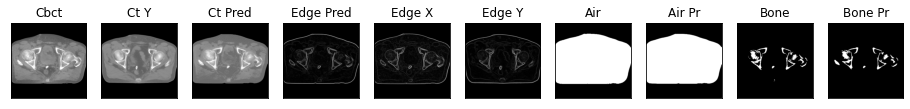

124it [00:49,  2.30it/s]

ssim score = 0.7435443997383118
psnr score = 20.959552764892578
snr score = 12.799735069274902
mae error = 0.04148150235414505
air dice score = 0.9963361496053003
bone dice score = 0.8892254872272117
contour dice score = 0.30073800683021545


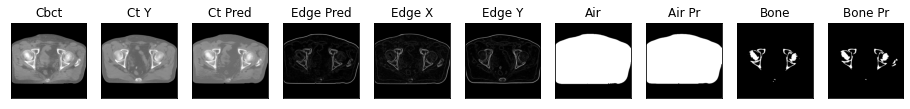

125it [00:49,  2.40it/s]

ssim score = 0.7425490021705627
psnr score = 21.150644302368164
snr score = 12.940177917480469
mae error = 0.039077699184417725
air dice score = 0.9964776084815501
bone dice score = 0.9187574671453728
contour dice score = 0.2882298529148102


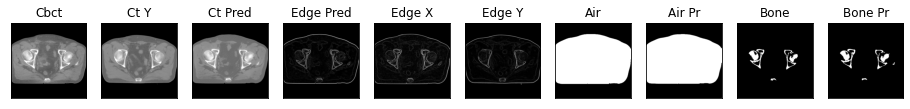

126it [00:50,  2.43it/s]

ssim score = 0.7410851120948792
psnr score = 21.01886558532715
snr score = 12.840555191040039
mae error = 0.0402248241007328
air dice score = 0.9965930232558159
bone dice score = 0.9042105263167978
contour dice score = 0.2827906906604767


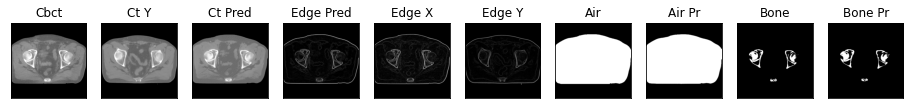

127it [00:50,  2.49it/s]

ssim score = 0.7360398769378662
psnr score = 20.75336456298828
snr score = 12.588530540466309
mae error = 0.04153674840927124
air dice score = 0.9965796999941653
bone dice score = 0.9159597330628213
contour dice score = 0.28170332312583923


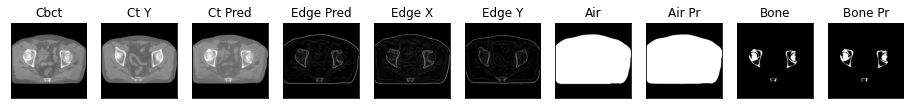

128it [00:50,  2.48it/s]

ssim score = 0.7384044528007507
psnr score = 20.38408088684082
snr score = 12.077754974365234
mae error = 0.04290677234530449
air dice score = 0.9962919067344158
bone dice score = 0.9255441008026856
contour dice score = 0.2504708170890808


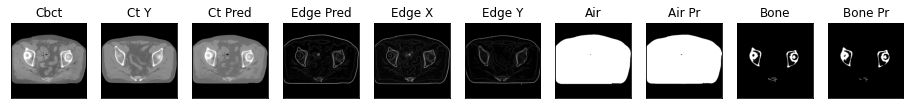

129it [00:51,  2.43it/s]

ssim score = 0.7439309358596802
psnr score = 20.42192268371582
snr score = 12.056288719177246
mae error = 0.04284214973449707
air dice score = 0.9963324606712444
bone dice score = 0.9187224097647531
contour dice score = 0.25556081533432007


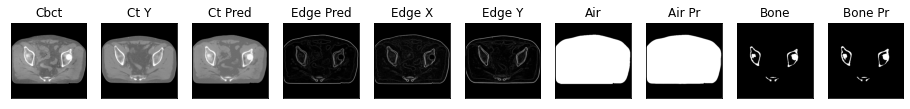

130it [00:51,  2.44it/s]

ssim score = 0.7399370074272156
psnr score = 20.749919891357422
snr score = 12.409934043884277
mae error = 0.04110841825604439
air dice score = 0.9963551883745347
bone dice score = 0.8574697613622513
contour dice score = 0.2556818127632141


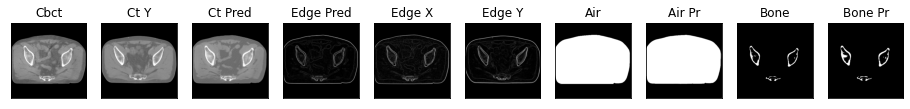

131it [00:52,  2.45it/s]

ssim score = 0.7342017292976379
psnr score = 20.689701080322266
snr score = 12.422529220581055
mae error = 0.04161439463496208
air dice score = 0.9959845099791504
bone dice score = 0.8845008619356762
contour dice score = 0.2302226424217224


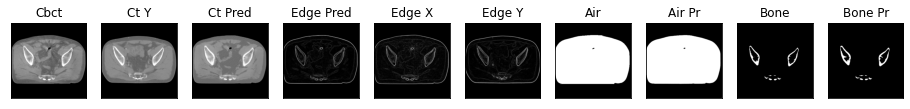

132it [00:52,  2.48it/s]

ssim score = 0.7287155985832214
psnr score = 20.346376419067383
snr score = 12.208434104919434
mae error = 0.043149787932634354
air dice score = 0.9961038649659562
bone dice score = 0.8990907735892221
contour dice score = 0.2442748099565506


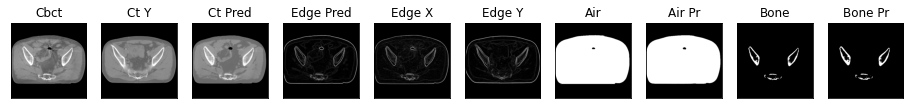

133it [00:53,  2.17it/s]

ssim score = 0.7236010432243347
psnr score = 20.196664810180664
snr score = 12.092680931091309
mae error = 0.04385586455464363
air dice score = 0.9959364298461415
bone dice score = 0.9017292281751479
contour dice score = 0.2696737051010132


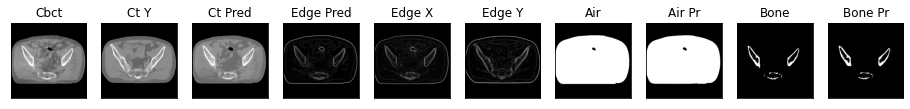

134it [00:53,  2.30it/s]

ssim score = 0.7172921299934387
psnr score = 20.272411346435547
snr score = 12.138638496398926
mae error = 0.044010140001773834
air dice score = 0.996070893176655
bone dice score = 0.9037230258489005
contour dice score = 0.24458353221416473


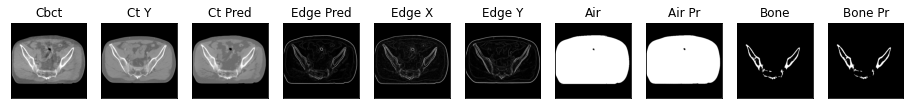

135it [00:53,  2.40it/s]

ssim score = 0.7138562202453613
psnr score = 20.466964721679688
snr score = 12.269815444946289
mae error = 0.04316290467977524
air dice score = 0.9962640854893707
bone dice score = 0.8767681916671751
contour dice score = 0.27632850408554077


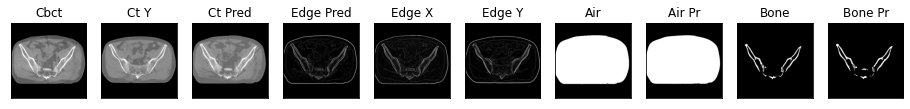

136it [00:54,  2.41it/s]

ssim score = 0.8174666166305542
psnr score = 22.939258575439453
snr score = 14.416647911071777
mae error = 0.029291236773133278
air dice score = 0.9973589720763247
bone dice score = 0.905137859833534
contour dice score = 0.4703517556190491


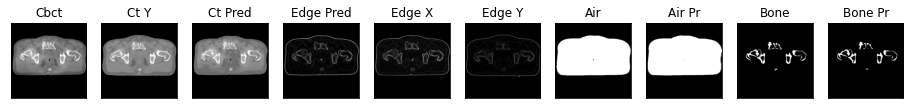

137it [00:54,  2.38it/s]

ssim score = 0.8204392790794373
psnr score = 23.12729263305664
snr score = 14.644697189331055
mae error = 0.02848930098116398
air dice score = 0.9972494796312836
bone dice score = 0.8936490041351165
contour dice score = 0.4762865900993347


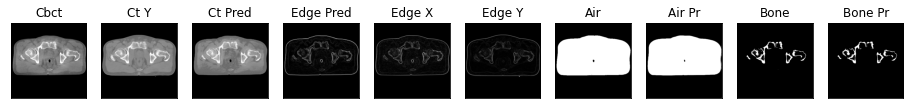

138it [00:55,  2.39it/s]

ssim score = 0.8203315734863281
psnr score = 23.32544708251953
snr score = 14.850639343261719
mae error = 0.028043879196047783
air dice score = 0.9974640618144247
bone dice score = 0.886743215032793
contour dice score = 0.4627847969532013


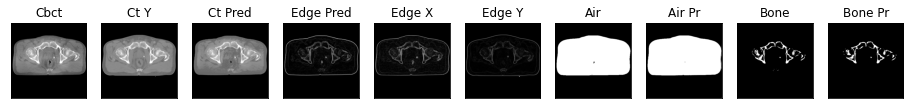

139it [00:55,  2.41it/s]

ssim score = 0.8254843354225159
psnr score = 23.29443359375
snr score = 14.76120376586914
mae error = 0.0275601614266634
air dice score = 0.9973364768377957
bone dice score = 0.8956935464206941
contour dice score = 0.48730963468551636


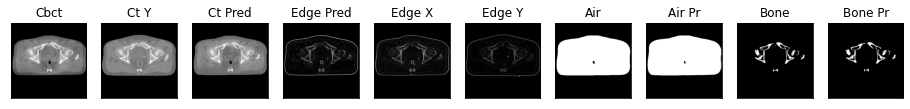

140it [00:55,  2.46it/s]

ssim score = 0.83355313539505
psnr score = 23.47081756591797
snr score = 14.781961441040039
mae error = 0.025672677904367447
air dice score = 0.997164128848818
bone dice score = 0.8858395812719502
contour dice score = 0.5117227435112


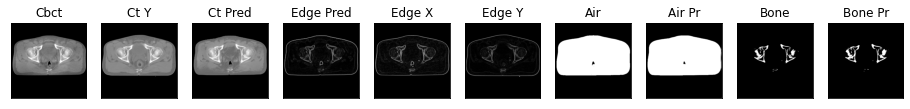

141it [00:56,  2.52it/s]

ssim score = 0.8360484838485718
psnr score = 23.649147033691406
snr score = 14.939488410949707
mae error = 0.025002654641866684
air dice score = 0.9972317871852022
bone dice score = 0.9113010953792239
contour dice score = 0.49667859077453613


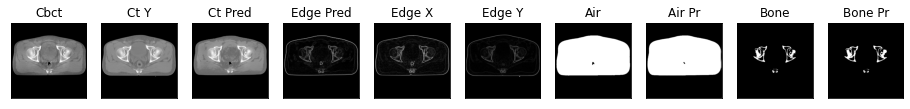

142it [00:56,  2.56it/s]

ssim score = 0.833700954914093
psnr score = 23.668899536132812
snr score = 14.943611145019531
mae error = 0.02433265559375286
air dice score = 0.9974858484885
bone dice score = 0.9129392971257596
contour dice score = 0.5284761190414429


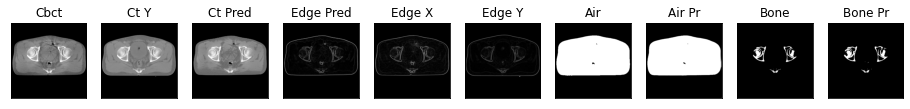

143it [00:57,  2.20it/s]

ssim score = 0.8268572092056274
psnr score = 23.023794174194336
snr score = 14.307872772216797
mae error = 0.02613135613501072
air dice score = 0.9970582229851874
bone dice score = 0.9088942957568411
contour dice score = 0.5095213651657104


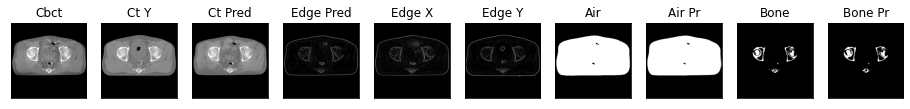

144it [00:57,  2.21it/s]

ssim score = 0.8235798478126526
psnr score = 23.06509780883789
snr score = 14.404955863952637
mae error = 0.026357470080256462
air dice score = 0.9967348237486673
bone dice score = 0.9175560298837039
contour dice score = 0.4467425048351288


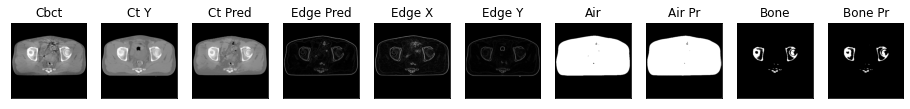

145it [00:58,  2.27it/s]

ssim score = 0.8207963109016418
psnr score = 22.722427368164062
snr score = 14.040355682373047
mae error = 0.02767154574394226
air dice score = 0.9962343955634362
bone dice score = 0.9287305122504352
contour dice score = 0.46417444944381714


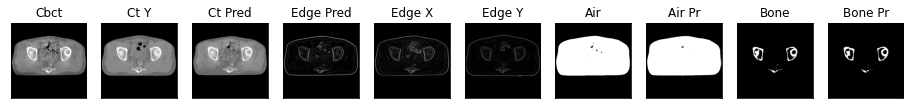

146it [00:58,  2.33it/s]

ssim score = 0.8230226039886475
psnr score = 22.176000595092773
snr score = 13.423152923583984
mae error = 0.028154201805591583
air dice score = 0.9964813189329493
bone dice score = 0.9210645015798968
contour dice score = 0.4527908265590668


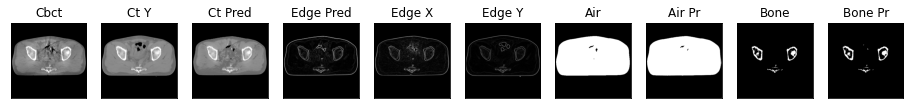

147it [00:58,  2.35it/s]

ssim score = 0.8235101103782654
psnr score = 22.527925491333008
snr score = 13.731188774108887
mae error = 0.026927199214696884
air dice score = 0.9971734148204758
bone dice score = 0.9175469020980995
contour dice score = 0.46726033091545105


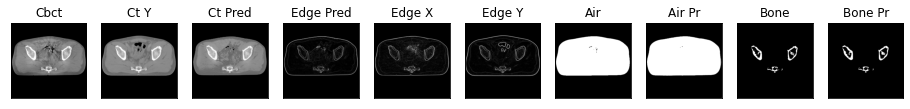

148it [00:59,  2.44it/s]

ssim score = 0.8268617987632751
psnr score = 22.682910919189453
snr score = 13.885074615478516
mae error = 0.026178540661931038
air dice score = 0.9970408304073864
bone dice score = 0.9261311172679881
contour dice score = 0.47238296270370483


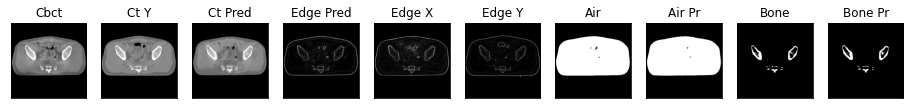

149it [00:59,  2.51it/s]

ssim score = 0.8233456611633301
psnr score = 22.84597396850586
snr score = 14.061494827270508
mae error = 0.026378802955150604
air dice score = 0.9964366250298258
bone dice score = 0.9250073811643784
contour dice score = 0.44257113337516785


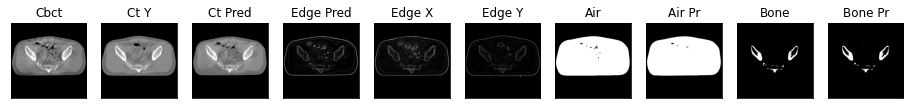

150it [00:59,  2.54it/s]

ssim score = 0.8244180679321289
psnr score = 22.77219009399414
snr score = 14.042917251586914
mae error = 0.02707674540579319
air dice score = 0.9968285400454858
bone dice score = 0.9233128834365629
contour dice score = 0.47860538959503174


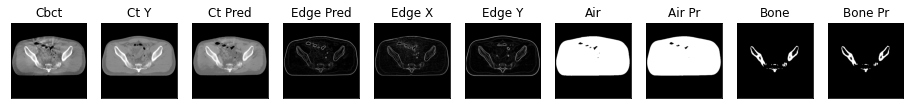

151it [01:00,  2.50it/s]

ssim score = 0.8248914480209351
psnr score = 22.30288314819336
snr score = 13.592978477478027
mae error = 0.02814987674355507
air dice score = 0.9968373564020303
bone dice score = 0.9138477801279883
contour dice score = 0.48516950011253357


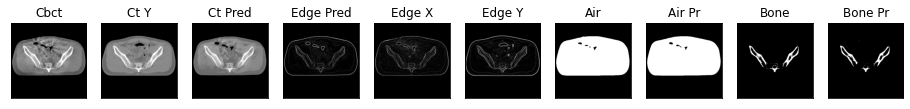

152it [01:00,  2.45it/s]

ssim score = 0.8280215263366699
psnr score = 22.339282989501953
snr score = 13.574640274047852
mae error = 0.0274076946079731
air dice score = 0.996528746319544
bone dice score = 0.902056666188666
contour dice score = 0.46684351563453674


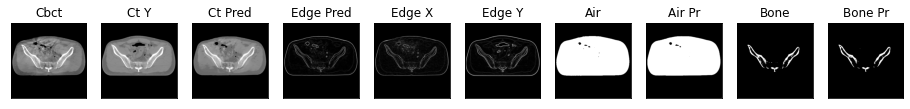

153it [01:01,  2.09it/s]

ssim score = 0.8317338228225708
psnr score = 22.58796501159668
snr score = 13.786968231201172
mae error = 0.02670089527964592
air dice score = 0.9971591568811126
bone dice score = 0.8859022018889634
contour dice score = 0.49147120118141174


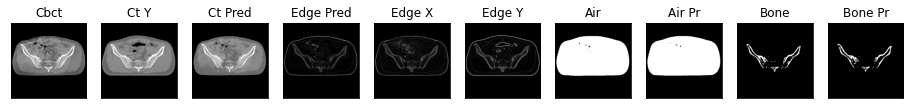

154it [01:01,  2.21it/s]

ssim score = 0.8354263305664062
psnr score = 22.695789337158203
snr score = 13.894867897033691
mae error = 0.026278046891093254
air dice score = 0.9968926531782525
bone dice score = 0.8788900414953463
contour dice score = 0.4427807629108429


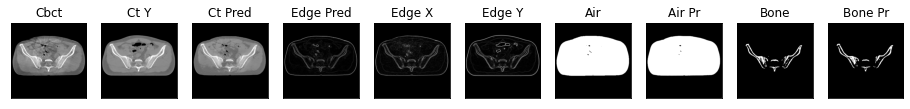

155it [01:02,  2.32it/s]

ssim score = 0.8356893062591553
psnr score = 23.011138916015625
snr score = 14.208791732788086
mae error = 0.02577848546206951
air dice score = 0.9972916973840457
bone dice score = 0.8904955961628698
contour dice score = 0.45831093192100525


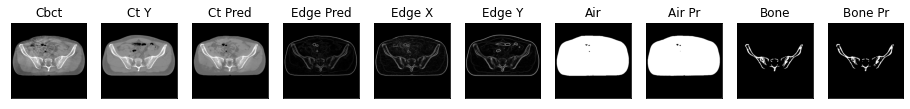

156it [01:02,  2.43it/s]

ssim score = 0.8284976482391357
psnr score = 22.552165985107422
snr score = 13.754861831665039
mae error = 0.026860052719712257
air dice score = 0.9972299168975091
bone dice score = 0.8801929777555589
contour dice score = 0.4298863112926483


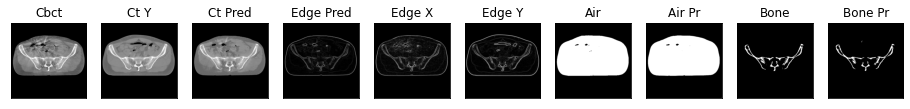

157it [01:02,  2.51it/s]

ssim score = 0.8235473036766052
psnr score = 22.002803802490234
snr score = 13.188224792480469
mae error = 0.02844337932765484
air dice score = 0.9965676577978307
bone dice score = 0.8703525860904053
contour dice score = 0.4596949815750122


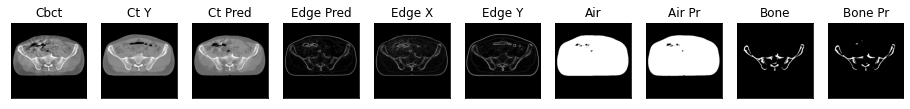

158it [01:03,  2.57it/s]

ssim score = 0.8193187117576599
psnr score = 21.69898223876953
snr score = 12.8657808303833
mae error = 0.02947821654379368
air dice score = 0.9967107070802252
bone dice score = 0.8450667364584524
contour dice score = 0.45334798097610474


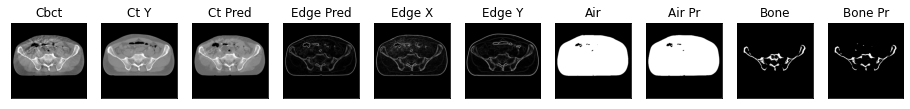

159it [01:03,  2.58it/s]

ssim score = 0.8125452995300293
psnr score = 21.35322380065918
snr score = 12.474081039428711
mae error = 0.03080715425312519
air dice score = 0.9963826651640438
bone dice score = 0.8400357462040082
contour dice score = 0.47324874997138977


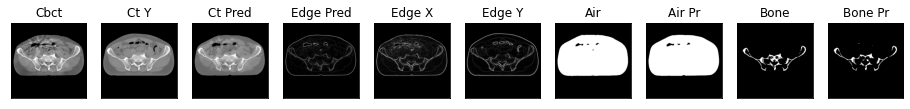

160it [01:04,  2.52it/s]

ssim score = 0.8082601428031921
psnr score = 21.361679077148438
snr score = 12.428739547729492
mae error = 0.031222568824887276
air dice score = 0.9959399460242369
bone dice score = 0.8655841777577148
contour dice score = 0.45863407850265503


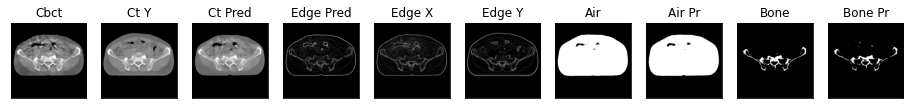

161it [01:04,  2.46it/s]

ssim score = 0.797682523727417
psnr score = 20.95526695251465
snr score = 12.052791595458984
mae error = 0.033325113356113434
air dice score = 0.995803662258396
bone dice score = 0.881376179669318
contour dice score = 0.474387526512146


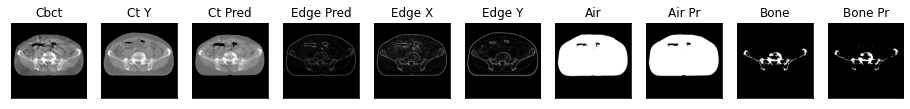

162it [01:04,  2.49it/s]

ssim score = 0.7916785478591919
psnr score = 20.664613723754883
snr score = 11.706911087036133
mae error = 0.03419284522533417
air dice score = 0.9957947051514895
bone dice score = 0.8741293532353964
contour dice score = 0.4716351628303528


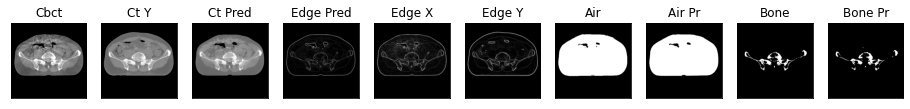

163it [01:05,  2.13it/s]

ssim score = 0.8011345863342285
psnr score = 21.26632308959961
snr score = 12.161087036132812
mae error = 0.03190423920750618
air dice score = 0.9958055564415842
bone dice score = 0.888236795102217
contour dice score = 0.3845723867416382


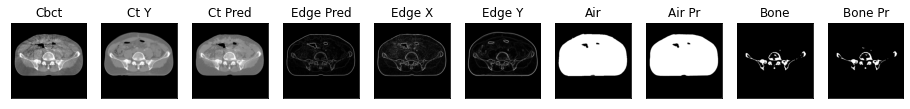

164it [01:05,  2.27it/s]

ssim score = 0.8492881059646606
psnr score = 24.191020965576172
snr score = 14.571934700012207
mae error = 0.027515258640050888
air dice score = 0.9957244445100866
bone dice score = 0.8848335388437772
contour dice score = 0.4878758490085602


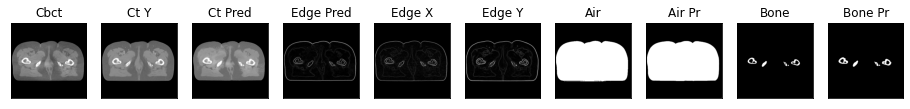

165it [01:06,  2.38it/s]

ssim score = 0.8503841757774353
psnr score = 24.498720169067383
snr score = 15.000643730163574
mae error = 0.02636105939745903
air dice score = 0.9954089415630167
bone dice score = 0.8859116600400688
contour dice score = 0.4676223397254944


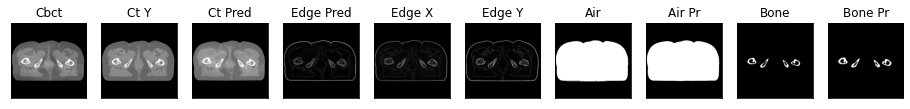

166it [01:06,  2.47it/s]

ssim score = 0.8470470309257507
psnr score = 24.583934783935547
snr score = 15.168776512145996
mae error = 0.025978906080126762
air dice score = 0.9957059642625444
bone dice score = 0.8816722657730184
contour dice score = 0.470703125


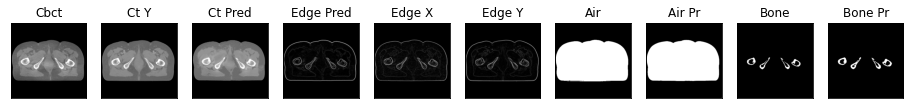

167it [01:07,  2.54it/s]

ssim score = 0.8457531929016113
psnr score = 24.619873046875
snr score = 15.268158912658691
mae error = 0.02570153772830963
air dice score = 0.9957193644344513
bone dice score = 0.8947547683941629
contour dice score = 0.45170730352401733


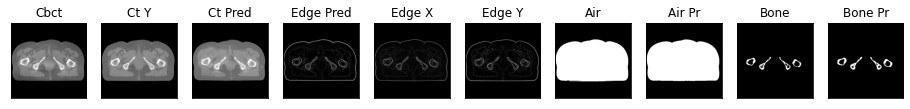

168it [01:07,  2.48it/s]

ssim score = 0.8457834720611572
psnr score = 24.562923431396484
snr score = 15.23967170715332
mae error = 0.025757497176527977
air dice score = 0.9958574619905901
bone dice score = 0.9111918124808321
contour dice score = 0.4387604594230652


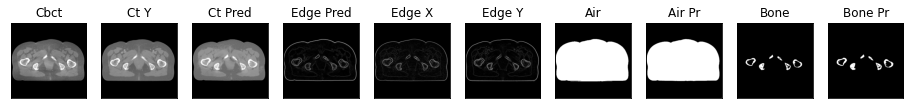

169it [01:07,  2.49it/s]

ssim score = 0.8485571146011353
psnr score = 24.501142501831055
snr score = 15.200843811035156
mae error = 0.025789162144064903
air dice score = 0.9955866445518169
bone dice score = 0.9108061749586482
contour dice score = 0.43622201681137085


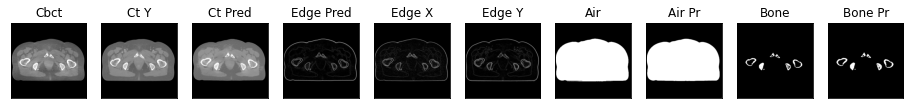

170it [01:08,  2.49it/s]

ssim score = 0.8439510464668274
psnr score = 24.43061065673828
snr score = 15.161642074584961
mae error = 0.02585000731050968
air dice score = 0.9954658644365469
bone dice score = 0.9034528997669552
contour dice score = 0.4318840503692627


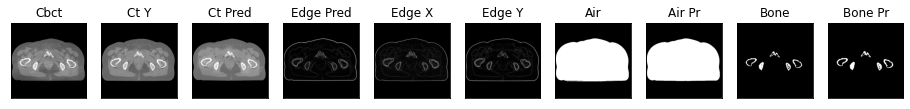

171it [01:08,  2.47it/s]

ssim score = 0.842487633228302
psnr score = 24.341279983520508
snr score = 15.120674133300781
mae error = 0.026119958609342575
air dice score = 0.9957022322519471
bone dice score = 0.8990376773789098
contour dice score = 0.41184768080711365


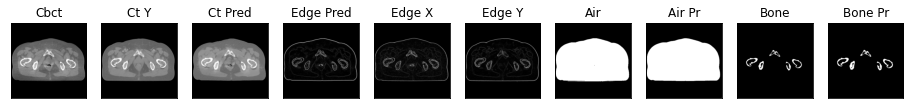

172it [01:09,  2.53it/s]

ssim score = 0.8424830436706543
psnr score = 24.11829376220703
snr score = 14.940431594848633
mae error = 0.026090310886502266
air dice score = 0.995628100956356
bone dice score = 0.8974992281584209
contour dice score = 0.44764649868011475


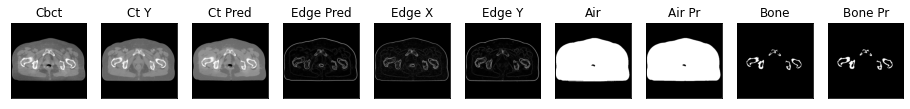

173it [01:09,  2.21it/s]

ssim score = 0.8412984013557434
psnr score = 24.107070922851562
snr score = 15.0169095993042
mae error = 0.025585630908608437
air dice score = 0.9954836389787879
bone dice score = 0.912071535023546
contour dice score = 0.44672897458076477


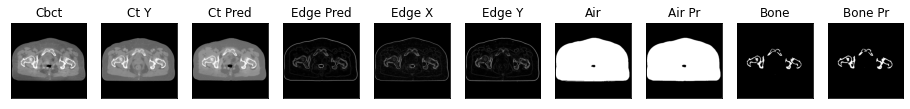

174it [01:10,  2.33it/s]

ssim score = 0.8418687582015991
psnr score = 24.995609283447266
snr score = 16.018720626831055
mae error = 0.024201279506087303
air dice score = 0.9954191479615241
bone dice score = 0.9138314041866732
contour dice score = 0.4328564703464508


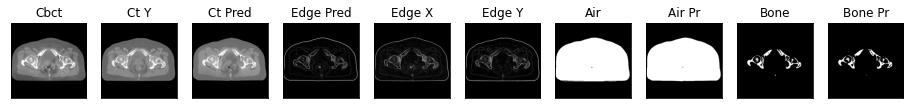

175it [01:10,  2.43it/s]

ssim score = 0.8400502800941467
psnr score = 24.30657958984375
snr score = 15.201138496398926
mae error = 0.025512754917144775
air dice score = 0.9950952975089309
bone dice score = 0.8755788823730228
contour dice score = 0.4175519645214081


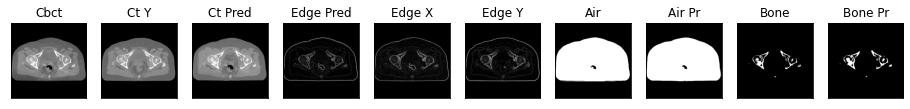

176it [01:10,  2.43it/s]

ssim score = 0.8419228196144104
psnr score = 24.185998916625977
snr score = 14.971137046813965
mae error = 0.026134079322218895
air dice score = 0.9948844340636545
bone dice score = 0.8531302876505392
contour dice score = 0.4308411180973053


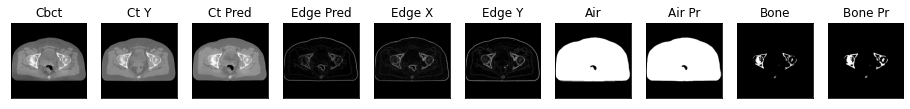

177it [01:11,  2.44it/s]

ssim score = 0.8465136885643005
psnr score = 24.161367416381836
snr score = 14.919378280639648
mae error = 0.02661469206213951
air dice score = 0.9950645324876649
bone dice score = 0.8921676345959477
contour dice score = 0.4516720175743103


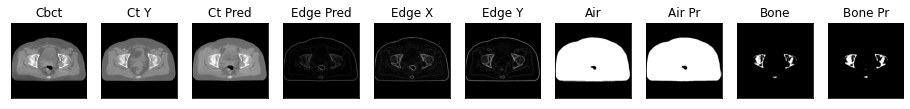

178it [01:11,  2.47it/s]

ssim score = 0.8494457006454468
psnr score = 24.708654403686523
snr score = 15.458662033081055
mae error = 0.026194386184215546
air dice score = 0.9955895366535729
bone dice score = 0.8934226553000393
contour dice score = 0.4164332449436188


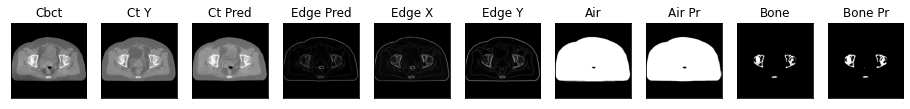

179it [01:12,  2.50it/s]

ssim score = 0.8494172692298889
psnr score = 25.285343170166016
snr score = 16.069580078125
mae error = 0.025073911994695663
air dice score = 0.995867333693512
bone dice score = 0.914698937427469
contour dice score = 0.42635294795036316


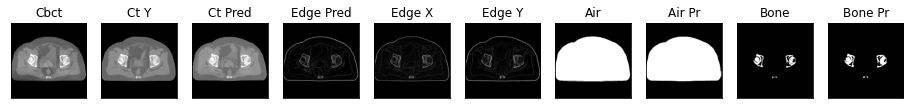

180it [01:12,  2.50it/s]

ssim score = 0.8465928435325623
psnr score = 24.9639892578125
snr score = 15.799718856811523
mae error = 0.025905365124344826
air dice score = 0.996281854894864
bone dice score = 0.925090252708708
contour dice score = 0.4896584749221802


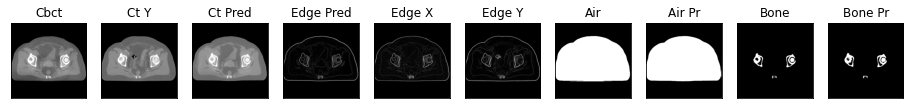

181it [01:12,  2.55it/s]

ssim score = 0.8353984951972961
psnr score = 24.182645797729492
snr score = 15.05593204498291
mae error = 0.027544014155864716
air dice score = 0.9964984011437199
bone dice score = 0.9059774853352469
contour dice score = 0.4845260977745056


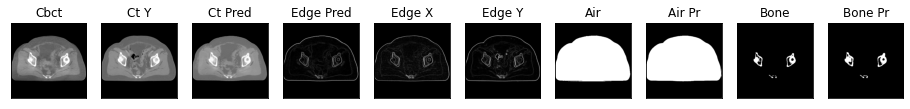

182it [01:13,  2.57it/s]

ssim score = 0.819298505783081
psnr score = 22.670747756958008
snr score = 13.471598625183105
mae error = 0.03170337527990341
air dice score = 0.9962311729960145
bone dice score = 0.8319312020969913
contour dice score = 0.4136919379234314


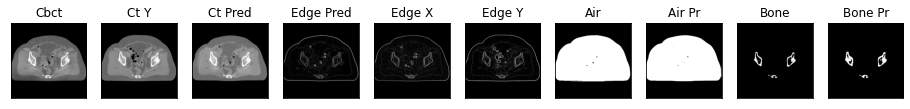

183it [01:13,  2.20it/s]

ssim score = 0.8097879886627197
psnr score = 22.22222137451172
snr score = 13.005075454711914
mae error = 0.034226346760988235
air dice score = 0.99575506088047
bone dice score = 0.8420254124816609
contour dice score = 0.4011857807636261


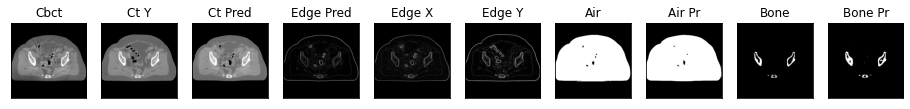

184it [01:14,  2.32it/s]

ssim score = 0.8043217658996582
psnr score = 22.699626922607422
snr score = 13.547396659851074
mae error = 0.0338873453438282
air dice score = 0.9960885867659383
bone dice score = 0.8744098205878298
contour dice score = 0.39920949935913086


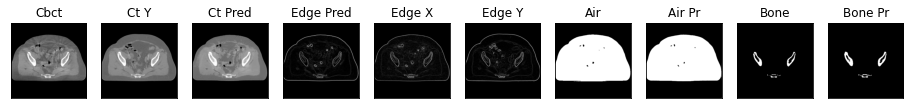

185it [01:14,  2.40it/s]

ssim score = 0.8074933886528015
psnr score = 22.867767333984375
snr score = 13.770633697509766
mae error = 0.03333690017461777
air dice score = 0.9961691971359259
bone dice score = 0.8939722825197199
contour dice score = 0.4039801061153412


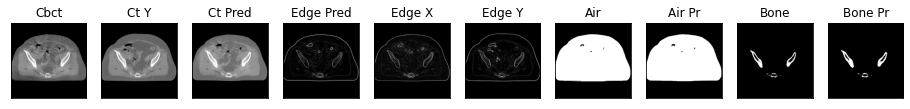

186it [01:14,  2.44it/s]

ssim score = 0.8039907813072205
psnr score = 22.263715744018555
snr score = 13.231008529663086
mae error = 0.0349651537835598
air dice score = 0.995973296598498
bone dice score = 0.8939266722656881
contour dice score = 0.3880157172679901


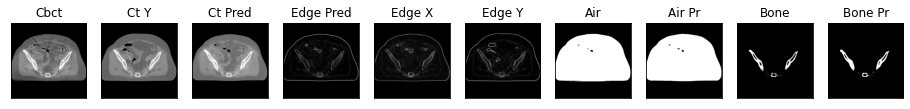

187it [01:15,  2.50it/s]

ssim score = 0.8031489849090576
psnr score = 22.247846603393555
snr score = 13.288002014160156
mae error = 0.03491409122943878
air dice score = 0.9957948960550896
bone dice score = 0.8724729815655121
contour dice score = 0.3518974781036377


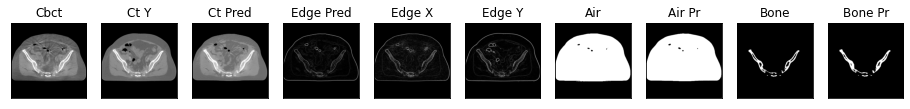

188it [01:15,  2.48it/s]

ssim score = 0.8041322231292725
psnr score = 22.19992446899414
snr score = 13.235788345336914
mae error = 0.035226091742515564
air dice score = 0.9956731959703408
bone dice score = 0.8457055991912122
contour dice score = 0.361328125


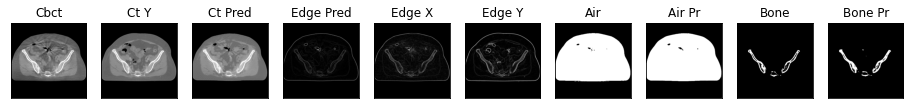

189it [01:16,  2.44it/s]

ssim score = 0.8063249588012695
psnr score = 22.120220184326172
snr score = 13.13390827178955
mae error = 0.03585139289498329
air dice score = 0.9961658124733762
bone dice score = 0.8596859933260022
contour dice score = 0.3485437035560608


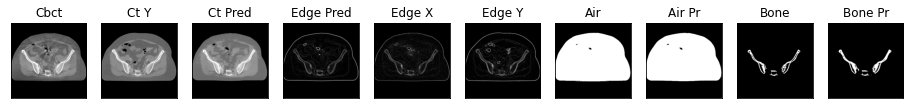

190it [01:16,  2.45it/s]

ssim score = 0.8090441226959229
psnr score = 22.64963150024414
snr score = 13.674954414367676
mae error = 0.034879762679338455
air dice score = 0.9962896147596589
bone dice score = 0.8667619914225041
contour dice score = 0.37704917788505554


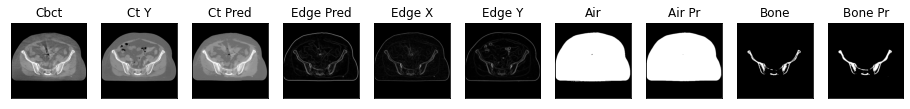

191it [01:17,  2.48it/s]


In [46]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [47]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [48]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [49]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:12, 14.73it/s]


(0.8274326561633205,
 23.355208232140665,
 14.35948032858484,
 0.02793156037701986,
 0.9963525302430399,
 0.8963392585215999,
 0.4590740479255846,
 0.4738219895287958,
 0.5)

In [50]:
# import torchvision.models as models
# models.vgg16(pretrained=True)